## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
!pip install -q svgpath2mpl svgpathtools filterpy keplergl
# !jupyter kernelspec list  # Does not work here

In [3]:
# !pip uninstall -y keplergl

In [4]:
# Standard library
import json
from math import ceil, isfinite
from pathlib import Path
from time import monotonic
from warnings import filterwarnings

# Plotting, figure settings, math
import matplotlib
import pandas as pd
import seaborn as sns
from filterpy.monte_carlo import systematic_resample
from keplergl import KeplerGl
from matplotlib import pyplot as plt
from matplotlib.transforms import Affine2D
from numpy import array, deg2rad, eye, mean, ndarray, pi, set_printoptions, stack
from numpy.random import seed, standard_normal
from seaborn import move_legend
from svgpath2mpl import parse_path
from svgpathtools import svg2paths

# ProMis
from promis import ProMis, StaRMap
from promis.geo import (
    CartesianCollection,
    CartesianMap,
    CartesianRasterBand,
    PolarCollection,
    PolarLocation,
)
from promis.loaders import NauticalChartLoader
from promis.logic.spatial import Depth, Relation


In [5]:
# Use full width of juptyer notebook
set_printoptions(linewidth=180, formatter={"float_kind": "{:4.6f}".format})
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

sns.set_theme(style="ticks", rc={"figure.figsize": (8, 3), "legend.title_fontsize": 15})
sns.set_style({"font.family": "serif", "font.serif": "Times New Roman"})

filterwarnings("ignore", module="tqdm.auto", message="IProgress not found")

## General setting

In [6]:
setting = "New York Harbor"
bbox = (
    # (lat, lon) lower left
    (40.4, -74.1),
    # (lat, lon) upper right
    (40.7, -73.8),
)

# setting = "Port of Charleston, South Carolina"
# bbox = (
#     # (lat, lon) lower left
#     (32.75, -79.97),
#     # (lat, lon) upper right
#     (32.875, -79.87),
# )

# setting = "Baltimore"
# bbox = (
#     # (lat, lon) lower left
#     (39.174, -76.6304993),
#     # (lat, lon) upper right
#     (39.29, -76.4495423),
# )

# setting = "Port of Virginia (Norfolk)"
# bbox = (
#     # (lat, lon) lower left
#     (36.7711453, -76.4994133),
#     # (lat, lon) upper right
#     (37.3020172, -75.8786833),
# )

In [7]:
origin = PolarLocation(
    latitude=mean([bbox[0][0], bbox[1][0]]), longitude=mean([bbox[0][1], bbox[1][1]])
)
width = PolarLocation(latitude=bbox[0][0], longitude=bbox[0][1]).distance(
    PolarLocation(latitude=bbox[0][0], longitude=bbox[1][1])
)
height = PolarLocation(latitude=bbox[0][0], longitude=bbox[0][1]).distance(
    PolarLocation(latitude=bbox[1][0], longitude=bbox[0][1])
)
dimensions = width, height
dimensions

(25468.03852707448, 33313.56617274144)

In [8]:
target_resolution = (200, 200)
support_resolution = (100, 100)

## Load chart data

This only needs to be done once.

In [ ]:
uam = NauticalChartLoader(
    chart_root=Path(".").absolute().parent / "data" / "us_charts-ny",  #  / "US4NY1AM"
    origin=origin,
    dimensions=dimensions,
).load_chart_data()

uam.apply_covariance(20.0 * eye(2))

In [186]:
print(f"Loaded {len(uam.features)} features")
print()

# for feature in uam.features:
#     # Water is visualized below anyways
#     if feature.location_type != "water":
#         print(f"{type(feature).__name__} - {feature.location_type}: \t{feature.name}")

Loaded 5877 features



In [187]:
uam.save("nautical_chart_uam.pkl")

## Prepare the mission landscape

In [189]:
# Load a UAM
uam = CartesianMap.load("nautical_chart_uam.pkl")

# We create a statistical relational map (StaR Map) to represent the
# stochastic relationships in the environment, computing a raster of 100 x 100 points
# using linear interpolation of a sample set
before = monotonic()
target = CartesianRasterBand(origin, target_resolution, width, height)
star_map = StaRMap(target, uam, method="nearest")

# The sample points for which the relations will be computed directly
support = CartesianRasterBand(origin, support_resolution, width, height)

# We now compute the Distance and Over relationships for the selected points
# For this, we take many random samples from generated/possible map variations
star_map.add_support_points(support, 25)
after = monotonic()

# star_map.save("nautical_chart_star_map.pkl")

runtime = after - before
runtime

640.4149391481187

## Visualize the relations

In [9]:
star_map = StaRMap.load("nautical_chart_star_map.pkl")

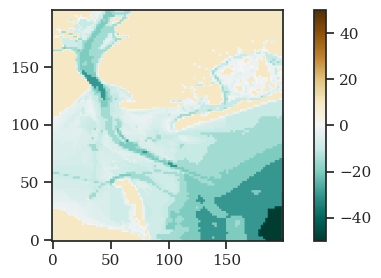

<Figure size 800x300 with 0 Axes>

In [10]:
# We first plot the depth since it is not asoociated with a specific location type
depth: Depth = star_map.get("depth", None)
depth.plot(target_resolution)
plt.show()
plt.clf()

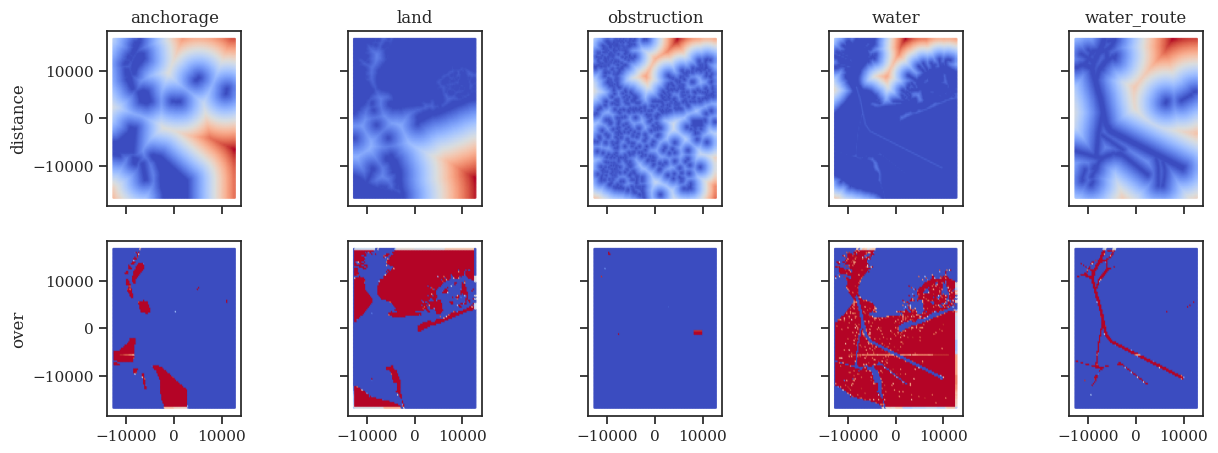

<Figure size 800x300 with 0 Axes>

In [11]:
# Plot an overview of the map
all_relation_types = sorted(star_map.relation_types - {"depth"})
all_location_types = sorted(set(star_map.location_types) - {None})

# Create one row per relation type and one column per location type
fig, axes = plt.subplots(
    len(all_relation_types), len(all_location_types), figsize=(15, 5), sharex=True, sharey=True
)

for i, relation_type in enumerate(all_relation_types):
    for j, location_type in enumerate(all_location_types):
        # Get the axis for the current row and column
        ax = axes[i, j]

        # Label the rows and columns
        if j == 0:
            ax.set_ylabel(relation_type)
        if i == 0:
            ax.set_title(location_type)

        # Get the relation and visualize it
        relation = star_map.get(relation_type, location_type)
        relation.parameters.scatter(axis=ax, cmap="coolwarm", s=0.1)

        # if j == len(all_location_types) - 1:
        #     plt.colorbar()

plt.show()
plt.clf()

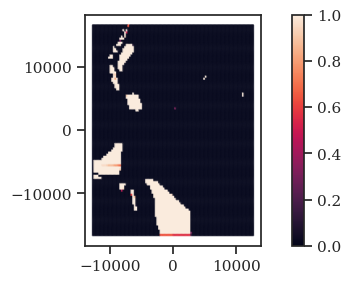

<Figure size 800x300 with 0 Axes>

In [12]:
relation = star_map.get("over", "anchorage")
relation.parameters.scatter(vmin=0, s=0.1)
plt.colorbar()
plt.show()
plt.clf()

In [13]:
def to_csv(relation: Relation, filename: Path) -> None:
    """Export the relations to a CSV file for further analysis."""
    cartesian_collection = relation.parameters
    cartesian_collection.dimensions = 2  # TODO make better in code
    polar_collection = cartesian_collection.to_polar()
    polar_collection.data.to_csv(filename, index=False)


folder = Path(f"export-relations-{setting}")
folder.mkdir(exist_ok=True)

for relation_type in all_relation_types:
    for location_type in all_location_types:
        to_csv(
            star_map.get(relation_type, location_type),
            folder / f"{relation_type}_{location_type}.csv",
        )

# Export the depth as well
to_csv(star_map.get("depth", None), folder / "depth.csv")

## Run some inference

In [14]:
# In ProMis, we define the constraints of the mission
# as hybrid probabilistic first-order logic programs

logic = """
landscape(X) :- over(X, water_route), depth(X) < -4.
"""

# Solve mission constraints using StaRMap parameters and multiprocessing
promis = ProMis(star_map, logic)
landscape = promis.solve(n_jobs=12, batch_size=10, show_progress=False)

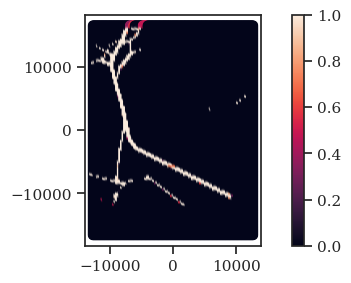

<Figure size 800x300 with 0 Axes>

In [15]:
# Show the resulting landscape
landscape.scatter()
plt.colorbar()
plt.show()
plt.clf()

In [16]:
promis.save("nautical_chart_promis.pkl")

### Query the landscape for specific locations

In [17]:
promis = ProMis.load("nautical_chart_promis.pkl")

In [18]:
def solve_at(promis: ProMis, query_locations: ndarray) -> CartesianCollection:
    """Solve the landscape at specific query locations.

    Note:
        Modifies the target of the ProMis object to the query locations.
    """

    # Validate the query location shape
    assert (
        len(query_locations.shape) == 2
    ), f"Query locations must be 2D, got {query_locations.shape}"
    assert query_locations.shape[1] == 2, "Query locations must be 2D"

    # Update the target of the ProMis object to the query locations
    new_target = CartesianCollection(
        origin=star_map.uam.origin, dimensions=star_map.target.dimensions
    )
    new_target.append_with_default(query_locations, value=0.0)
    promis.star_map.target = new_target

    # Solve the ProMis inference problem at the target locations
    return promis.solve(n_jobs=12, batch_size=10, show_progress=False)


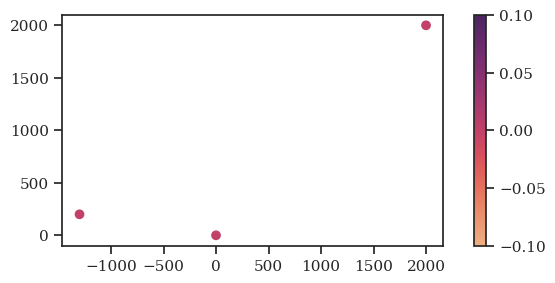

,east,north,v0
0,-1300.0,200.0,0.0
1,0.0,0.0,0.0
2,2000.0,2000.0,0.0


<Figure size 800x300 with 0 Axes>

In [19]:
# Showcase the solution at specific locations
result = solve_at(promis, query_locations=array([[-1300, 200], [0, 0], [2000, 2000]]))

# Show the resulting landscape
result.scatter(cmap="flare")
plt.colorbar()
plt.show()
plt.clf()

# The resulting datafram retains the order of the query locations
# The relevant inference solution could now be extracted using the `v0` key
result.data

## Load some AIS data

In [20]:
vessel_types = json.loads((Path("..") / "data" / "vessel_types_simplified.json").read_text())
# vessel_types

In [21]:
def load_ais(
    path: str | Path, bbox: None | tuple[tuple[float, float], tuple[float, float]]
) -> pd.DataFrame:
    # Read the csv into pandas
    df = pd.read_csv(path)

    # Filter by bounding box
    if bbox is not None:
        # This is a overly simplistic bounding box filter that only works on moderate latitudes
        # and far from the dateline
        df = df[
            (df["LAT"] > bbox[0][0])
            & (df["LAT"] < bbox[1][0])
            & (df["LON"] > bbox[0][1])
            & (df["LON"] < bbox[1][1])
        ]

    # Sort by time per ship
    df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])
    df.sort_values(["MMSI", "BaseDateTime"], inplace=True)

    df.loc[df["VesselType"].isna(), "VesselType"] = 0  # Zero means unknown

    df["VesselType"] = df["VesselType"].astype(int)
    df["VesselTypeName"] = df["VesselType"].astype(str).map(vessel_types)

    # Filter out all vessels that have an average SOG of less than 1 knot
    df = df.groupby("MMSI").filter(lambda x: x["SOG"].mean() > 1)

    return df


df = load_ais(Path("..") / "data" / "ais" / "AIS_2023_08_01.csv", bbox=bbox)
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName
6356009,232040168,2023-08-01 18:14:16,40.41563,-74.02070,102.3,71.0,106.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
6390267,232040168,2023-08-01 18:22:00,40.41702,-74.01857,5.5,31.8,41.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
6391376,232040168,2023-08-01 18:24:03,40.42008,-74.01790,7.9,349.8,2.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
6418027,232040168,2023-08-01 18:27:35,40.42827,-74.01943,9.5,352.2,358.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
6419256,232040168,2023-08-01 18:28:39,40.43095,-74.02005,9.5,353.6,358.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147846,636092711,2023-08-01 06:25:17,40.42155,-73.81043,12.9,188.2,189.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo
2153611,636092711,2023-08-01 06:26:28,40.41710,-73.81103,13.9,184.8,186.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo
2181613,636092711,2023-08-01 06:27:31,40.41290,-73.81142,14.6,183.5,185.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo
2158175,636092711,2023-08-01 06:28:37,40.40835,-73.81178,15.1,183.7,185.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo


In [22]:
collection = PolarCollection(origin=origin, dimensions=0)
collection.append_with_default(df[["LON", "LAT"]].values, value=())
cartesian = collection.to_cartesian()

df.loc[:, "East"] = cartesian.data["east"].values
df.loc[:, "North"] = cartesian.data["north"].values
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName,East,North
6356009,232040168,2023-08-01 18:14:16,40.41563,-74.02070,102.3,71.0,106.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-6000.582615,-14918.571967
6390267,232040168,2023-08-01 18:22:00,40.41702,-74.01857,5.5,31.8,41.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-5819.681496,-14764.365122
6391376,232040168,2023-08-01 18:24:03,40.42008,-74.01790,7.9,349.8,2.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-5762.556086,-14424.618369
6418027,232040168,2023-08-01 18:27:35,40.42827,-74.01943,9.5,352.2,358.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-5891.689951,-13515.076873
6419256,232040168,2023-08-01 18:28:39,40.43095,-74.02005,9.5,353.6,358.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-5944.065951,-13217.440337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147846,636092711,2023-08-01 06:25:17,40.42155,-73.81043,12.9,188.2,189.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo,11844.809203,-14254.245115
2153611,636092711,2023-08-01 06:26:28,40.41710,-73.81103,13.9,184.8,186.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo,11794.666422,-14748.465626
2181613,636092711,2023-08-01 06:27:31,40.41290,-73.81142,14.6,183.5,185.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo,11762.297638,-15214.896822
2158175,636092711,2023-08-01 06:28:37,40.40835,-73.81178,15.1,183.7,185.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo,11732.531930,-15720.188438


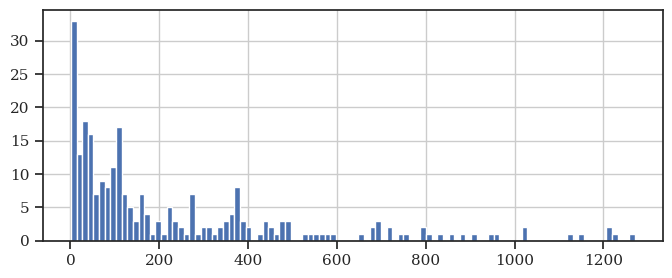

In [23]:
df["MMSI"].value_counts().hist(bins=100)
pass

In [24]:
MMSIs = df["MMSI"].value_counts()
min_observations = 10 + 20 + 15  # warmup + some usage in between + dead_reckoning
relevant_MMSIs = MMSIs[MMSIs > min_observations].index
df = df[df["MMSI"].isin(relevant_MMSIs)]

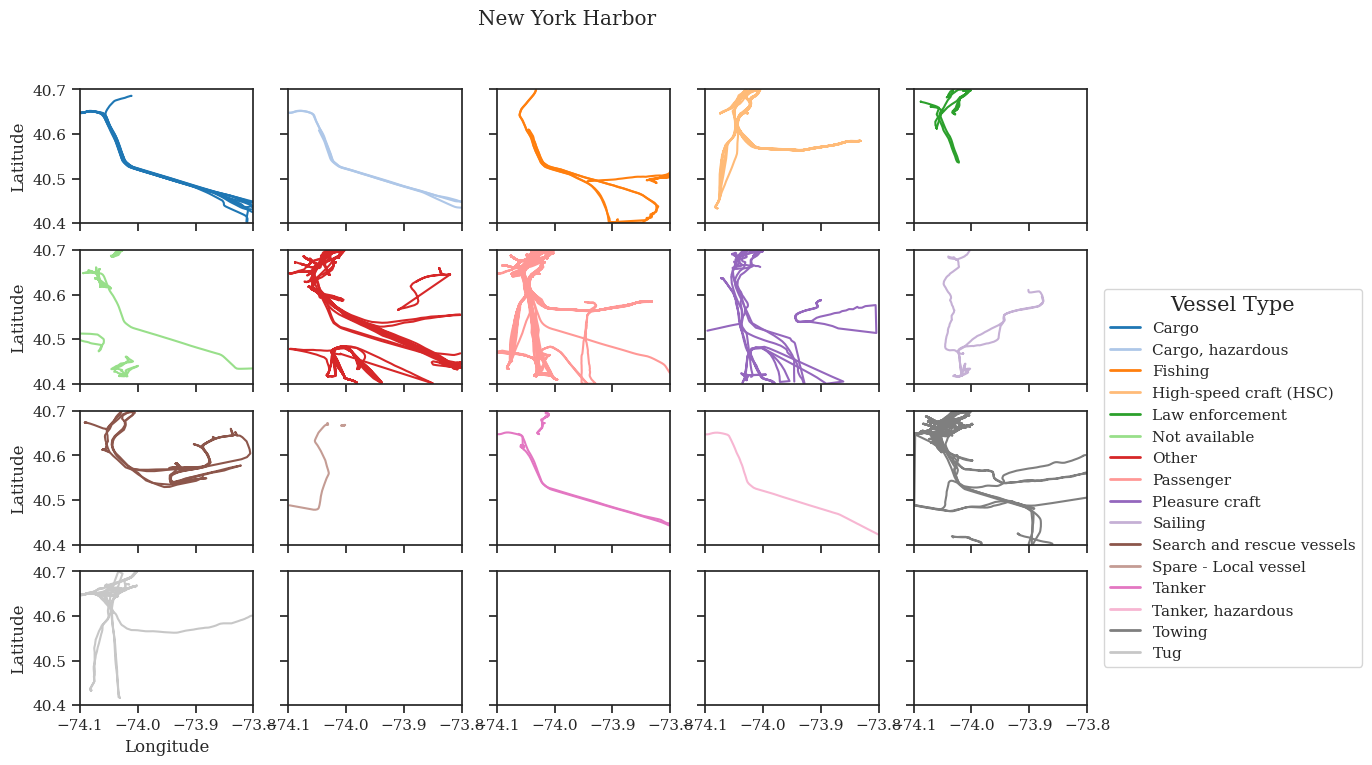

<Figure size 800x300 with 0 Axes>

In [25]:
vessel_type_to_index = {
    vessel_type: i for i, vessel_type in enumerate(sorted(df["VesselTypeName"].unique()))
}
palette = sns.color_palette("tab20", len(vessel_type_to_index))

relevant_vessel_types = df["VesselTypeName"].unique()

cols = 5
all_rows = ceil(len(relevant_vessel_types) / cols)
fig, ax = plt.subplots(ncols=cols, nrows=all_rows, figsize=(13, 8), sharex=True, sharey=True)

for (vessel_type, i), ax in zip(vessel_type_to_index.items(), ax.flatten()):
    for mmsi in relevant_MMSIs:
        df_ = df[df["MMSI"] == mmsi]
        if relevant_vessel_types is not None and df_["VesselTypeName"].iloc[0] != vessel_type:
            continue
        vessel_type = df_["VesselTypeName"].iloc[0]
        color = palette[vessel_type_to_index[vessel_type]]
        ax.plot(df_["LON"], df_["LAT"], c=color)
        # plt.scatter(df_["LON"], df_["LAT"], c=df_["SOG"], cmap="viridis", s=8)

    # plt.colorbar()

    ax.set_xlim(bbox[0][1], bbox[1][1])
    if i // cols == all_rows - 1:
        ax.set_xlabel("Longitude")
    ax.set_ylim(bbox[0][0], bbox[1][0])
    if i % cols == 0:
        ax.set_ylabel("Latitude")
    # ax.set_aspect("equal")

    # if the center right ahdn side
    col = i % cols
    row = i // cols
    if col == cols - 1 and row == len(relevant_vessel_types) // cols - 1:
        ax.legend(
            [
                plt.Line2D([0], [0], color=palette[i], lw=2, label=vessel_type)
                for i, vessel_type in enumerate(vessel_type_to_index)
            ],
            vessel_type_to_index.keys(),
            title="Vessel Type",
            loc="center left",
            bbox_to_anchor=(1.05, 0.5),
        )

plt.suptitle(setting)

plt.savefig(Path(".") / "plots" / f"ais-{setting}-some.pdf", bbox_inches="tight")

plt.show()
plt.clf()

pass

In [26]:
vessel_type = "Search and rescue vessels"
df_ = df[df["VesselTypeName"] == vessel_type]
path = Path(".") / "plots" / f"ais-{setting}-trace"
path.mkdir(exist_ok=True)
df_[["LON", "LAT", "MMSI"]].to_csv(path / f"{vessel_type}.csv", index=False)

In [27]:
relevant_vessel_types = [
    "Cargo",
    "Cargo hazardous",
    "Search and rescue vessels",
    "Towing",
    "Other",
    "Tanker",
    "Tanker hazardous",
    # "Passenger",
]

In [28]:
# for mmsi in relevant_MMSIs:
#     df_ = df[df["MMSI"] == mmsi]
#     if df_["VesselTypeName"].iloc[0] not in relevant_vessel_types:
#         continue

#     plt.plot(df_["LON"], df_["LAT"], c=color)
#     plt.xlim(bbox[0][1], bbox[1][1])
#     plt.ylim(bbox[0][0], bbox[1][0])
#     plt.gca().set_aspect("equal")

#     path = Path(".") / "plots" / f"ais-{setting}" / df_["VesselTypeName"].iloc[0]
#     path.mkdir(exist_ok=True, parents=True)
#     plt.savefig(path / f"{mmsi}.pdf", bbox_inches="tight")
#     plt.clf()

# pass

In [29]:
track_mmsi = 636017103
track_mmsi

636017103

## Use the landscape to filter with agent constitution

In [30]:
import numpy as np
from matplotlib.animation import FuncAnimation
from scipy.stats import norm, uniform

from promis.estimators.filters.particle import (
    ParticleFilter,
    gaussian_noise,
    independent_sample,
    squared_error,
)

ship_marker = parse_path(svg2paths("ship-icon.svg")[1][0]["d"])
ship_marker.vertices -= ship_marker.vertices.mean(axis=0)
ship_marker = ship_marker.transformed(Affine2D().rotate_deg(180)).transformed(
    Affine2D().scale(-1, 1)
)

In [31]:
df_ = df[df["MMSI"] == track_mmsi]
df_

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName,East,North
3960115,636017103,2023-08-01 11:49:35,40.44721,-73.80007,6.3,267.2,270.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,12719.189958,-11403.440125
4007616,636017103,2023-08-01 11:50:44,40.44706,-73.80274,6.3,267.0,270.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,12492.710366,-11420.477721
3975932,636017103,2023-08-01 11:51:55,40.44698,-73.80548,6.3,267.8,270.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,12260.278629,-11429.745157
8645385,636017103,2023-08-01 11:53:06,40.44686,-73.80823,6.3,267.9,270.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,12027.005130,-11443.448475
3989953,636017103,2023-08-01 11:54:15,40.44682,-73.81085,6.1,269.9,276.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,11804.745333,-11448.243697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4648379,636017103,2023-08-01 13:40:39,40.64977,-74.08801,5.8,246.1,245.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-11672.743889,11088.235617
4630139,636017103,2023-08-01 13:41:48,40.64906,-74.09025,5.8,247.6,246.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-11862.326566,11009.691808
4657127,636017103,2023-08-01 13:42:58,40.64832,-74.09258,5.9,247.5,247.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-12059.530932,10927.833752
4646210,636017103,2023-08-01 13:44:09,40.64769,-74.09501,6.0,256.7,259.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-12265.177691,10858.210053


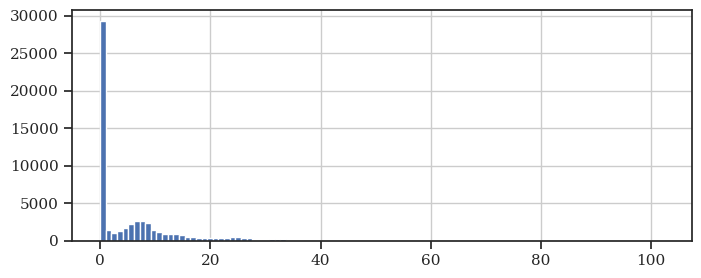

In [32]:
df["SOG"].hist(bins=100)
pass

In [33]:
# plt.plot(np.arange(len(df_["RelativeTime"])), df_["RelativeTime"].diff())
# pass

In [34]:
# Load it again since we modified it
promis.star_map = StaRMap.load("nautical_chart_star_map.pkl")

In [35]:
def landscape_for_mmsi(mmsi: int):
    metadata = df[df["MMSI"] == mmsi].iloc[0]

    logic = r"""% Background knowledge
    is_deep(X) :- A is depth(X), B is current_draft , A + B < -1.

    0.95::is_safe(X) :- is_deep(X), distance(X, land) > 50. %, \+ over(X, anchorage).

    bound_to_main_routes :- is_cargo ; is_cargo_hazardous ;
        is_tanker ; is_tanker_hazardous ; length > 100.
    follows_main_routes(X) :- \+  bound_to_main_routes ; distance(X, water_route) < 400 ;
        distance(X, water_route) > 2000.
    %is_sane_speed(X) :- \+ over(X, anchorage) ; speed_over_ground < 10.
    is_legal(X) :- follows_main_routes(X). %, is_sane_speed(X).

    is_useful(X) :- \+ is_search_and_rescue_vessels.
    0.2::is_useful(X) :- is_search_and_rescue_vessels.
    0.8::is_useful(X) :- is_search_and_rescue_vessels, distance(X, land) < 500.

    % This rule set does not model all possible bahavioral patterns of ships
    %0.1::is_ignorant.
    landscape(X) :- is_safe(X), is_legal(X), is_useful(X). % ; is_ignorant.
    % landscape(X) :- is_deep(X).
    """

    vessel_type = metadata["VesselTypeName"].replace(" ", "_").lower()
    logic += f"\nis_{vessel_type}."
    for vessel_type in relevant_vessel_types:
        if vessel_type != metadata["VesselTypeName"]:
            logic += f"\n0::is_{vessel_type.replace(' ', '_').lower()}."

    length = metadata["Length"]
    if isfinite(length) and length > 0:
        logic += f"\nlength ~ normal({length}, {length*0.05})."
    else:
        # Some prior knowledge
        logic += "\nlength ~ normal(30, 10)."

    draft = metadata["Draft"]
    if isfinite(length) and draft > 0:
        logic += f"\ncurrent_draft ~ normal({draft}, {draft*0.1})."
    else:
        # Some prior knowledge
        logic += "\ncurrent_draft ~ normal(2, 1)."

    # TODO: Time varying!
    # speed_over_ground = metadata["SOG"]
    # if isfinite(speed_over_ground):
    #     logic += f"\nspeed_over_ground ~ normal({speed_over_ground}, {speed_over_ground*0.1})."
    # else:
    #     # Some prior knowledge
    #     logic += "\nspeed_over_ground ~ normal(5, 5)."

    logic += "\n\n"  # Add newlines for better readability

    promis = ProMis(star_map, logic)
    landscape = promis.solve(n_jobs=12, batch_size=5, show_progress=False)

    return landscape


landscapes = {
    "Cargo": landscape_for_mmsi(636017103),
    # "Search and rescue vessels": landscape_for_mmsi(367531710),
    # "Towing": landscape_for_mmsi(303461000),
}
landscape = landscapes["Cargo"]

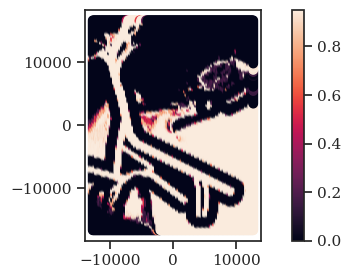

<Figure size 800x300 with 0 Axes>

In [36]:
landscape.scatter()
plt.colorbar()
plt.show()
plt.clf()

In [37]:
path = Path(".") / "plots" / f"ais-{setting}-trace"

for vessel_type, landscape in landscapes.items():
    polar_collection = landscape.to_polar()
    polar_collection.data.to_csv(path / f"{vessel_type}-landscape.csv", index=False)

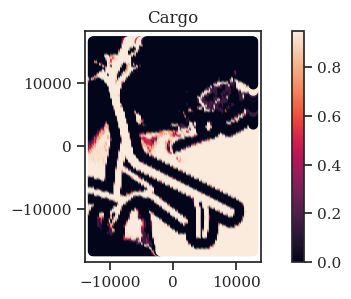

<Figure size 800x300 with 0 Axes>

In [38]:
for vessel_type, landscape in landscapes.items():
    landscape.scatter()
    plt.colorbar()
    plt.title(vessel_type)
    plt.show()
    plt.clf()

In [39]:
interpolators = {
    vessel_type: landscape.get_interpolator(method="nearest")
    for vessel_type, landscape in landscapes.items()
}
interpolator = interpolators["Cargo"]

In [40]:
typical_ship_speed = 5  # meters per second
typical_sample_time = 60  # seconds

In [41]:
# simulation_duration = df_["RelativeTime"].iloc[-1].item()
# num_simulation_steps = len(df_["RelativeTime"])
# num_simulation_steps, simulation_duration

In [42]:
def plot_trajectories(all_positions: ndarray, label: str | None = "Trajectory {}", **kwargs):
    if len(all_positions.shape) == 2:
        all_positions = all_positions[None, ...]
    for i, positions in enumerate(all_positions):
        plt.plot(*zip(*positions), label=label.format(i) if label else None, **kwargs)

/tmp/ipykernel_193577/3080782146.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


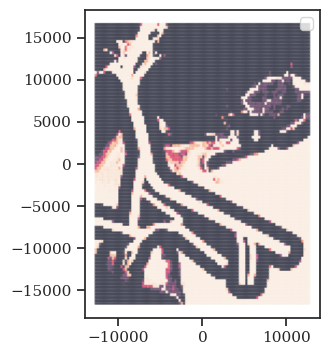

<Figure size 800x300 with 0 Axes>

In [43]:
plt.figure(figsize=(6, 4))
landscape.scatter(s=0.2, alpha=0.5)
# plot_trajectories(stack((df_["East"], df_["North"])), label="True trajectory")
plt.legend()
plt.show()
plt.clf()
pass

In [44]:
def plot_trajectories_animated(positions, filename: str = "trajectory.gif") -> None:
    fig, _ = plt.subplots()
    landscape.scatter()
    (line,) = plt.plot(*zip(*positions), label="Ship Position")
    plt.colorbar()

    def update(num, x, y, line):
        line.set_data(x[:num], y[:num])
        line.axes.axis([-width / 2, width / 2, -height / 2, height / 2])
        return (line,)

    ani = FuncAnimation(
        fig,
        update,
        len(positions),
        fargs=[positions[:, 0], positions[:, 1], line],
        interval=1000 / 60,
        blit=True,
    )
    ani.save(filename)
    plt.clf()


# plot_trajectories_animated(ground_truth)

## Old particle filter code

In [41]:
def run_experiment(
    data: pd.DataFrame,
    dead_reckoning_steps: int = 15,
    verbose: bool = False,
    seed_value: int = 2024,
    eval_skip_warmup: int = 10,
    with_constitution: bool = True,
    constitutional_trust: float = 0.8,
) -> dict:
    seed(seed_value)

    # We define the first and second derivatives in polar coordinates
    # since that is how the AIS data is given (for boat speed and direction)
    # and is is quite natural for the problem at hand (ships change direction
    # more often than speed)
    # column_names = ["x", "y", "dphi", "dr"]  # , "ddphi", "ddr"]
    column_names = ["x", "y", "dx", "dy"]  # , "ddphi", "ddr"]

    # prior sampling function for each variable
    prior_fn = independent_sample(
        [
            uniform(loc=-width / 2, scale=width).rvs,
            uniform(loc=-height / 2, scale=height).rvs,
            # uniform(loc=0, scale=2 * pi).rvs,
            # norm(loc=typical_ship_speed, scale=typical_ship_speed).rvs,
            norm(loc=0, scale=typical_ship_speed).rvs,
            norm(loc=0, scale=typical_ship_speed).rvs,
            # norm(loc=0, scale=0.01 * 2 * pi).rvs,
            # norm(loc=0, scale=0.01 * typical_ship_speed).rvs,
        ]
    )

    def polar_to_cartesian(phi: ndarray, r: ndarray) -> ndarray:
        """Convert polar coordinates to cartesian."""
        return stack((r * np.sin(phi), r * np.cos(phi)), axis=1)

    dt = None

    def state_forward_model(x: ndarray) -> ndarray:
        """Very simple linear dynamics: pos += dpos and dpos += ddpos."""
        nonlocal dt

        xp = np.array(x)

        # However, we need to convert the polar coordinates to cartesian
        # dxy = polar_to_cartesian(xp[:, 2], xp[:, 3])
        # xp[:, 0] += dxy[:, 0] * dt
        # xp[:, 1] += dxy[:, 1] * dt

        xp[:, [0, 1]] += xp[:, [2, 3]] * dt

        # xp[:, 2] %= 2 * pi
        # xp[:, 3] = clip(xp[:, 3], 0, None)

        # First and second derivatives are both in polar coordinates
        # xp[:, [2, 3]] += xp[:, [4, 5]] * dt

        return xp

    trace_weight_e1 = []
    trace_weight_e2 = []

    def weight_fn(hyp, obs) -> ndarray:
        nonlocal trace_weight_e1, trace_weight_e2, with_constitution, constitutional_trust

        # Make sure everything is in cartesian coordinates for proper distance computation
        # Also make sure that the rough scales are the same
        # hyp = hyp.copy()
        # hyp[:, [2, 3]] = polar_to_cartesian(hyp[:, 2], hyp[:, 3])
        # hyp[:, 2] /= typical_ship_speed
        # hyp[:, 3] /= typical_ship_speed
        # obs = obs.copy()
        # obs[:, [2, 3]] = polar_to_cartesian(obs[:, 2], obs[:, 3])
        # obs[:, 2] /= typical_ship_speed
        # obs[:, 3] /= typical_ship_speed

        # Compute by distance to observations
        # speed = obs[0, 3]
        # from numpy import clip
        # speed = clip(speed, 0.5, 10)
        # e1 = squared_error(hyp[:, :2], obs[:, :2], sigma=typical_sample_time * speed * 0.5)
        # e2 = squared_error(hyp[:, 2:], obs[:, 2:], sigma=speed * 0.2)
        # weight = e1 * e2

        weight = squared_error(hyp[:, :2], obs[:, :2], sigma=5)

        trace_weight_e1.append(-1)
        trace_weight_e2.append(-1)

        if with_constitution:
            # constitution = solve_at(promis, hyp[:, :2]).data["v0"].to_numpy()
            constitution = interpolator(hyp[:, :2])[:, 0]

            # plt.hist(from_landscape)
            # plt.xlabel("Landscape Value")
            # plt.ylabel("Frequency")
            # plt.show()
            # plt.clf()

            weight *= constitutional_trust * constitution + (1 - constitutional_trust)
        return weight

    # create the filter
    pf = ParticleFilter(
        prior_fn=prior_fn,
        observe_fn=lambda x: x[:, :4],
        n_particles=2000,
        dynamics_fn=state_forward_model,
        noise_fn=lambda x: gaussian_noise(
            x,
            sigmas=[
                5,
                5,
                0.2,
                0.2,
                # typical_ship_speed * typical_sample_time / 0.5,
                # typical_ship_speed * typical_sample_time / 0.5,
                # 0.03 * 2 * pi,
                # typical_ship_speed * 0.05,
                # typical_ship_speed * 0.5,
                # typical_ship_speed * 0.5,
                # 0.02**2 * 2 * pi,
                # typical_ship_speed * 0.05**2,
            ],
        ),
        weight_fn=weight_fn,
        resample_proportion=0.01,
        n_eff_threshold=0.5,
        column_names=column_names,
    )

    trace_time = []
    trace_all_particles = [pf.particles.copy()]  # only here we already have the initial particles
    trace_state = []
    trace_map_state = []
    trace_hypotheses = []
    trace_map_hypotheses = []
    trace_weights = []
    trace_weights_unnormalized = []

    data.loc[:, "RelativeTime"] = (
        data["BaseDateTime"] - data["BaseDateTime"].iloc[0]
    ).dt.total_seconds()
    assert data["RelativeTime"].is_monotonic_increasing

    ground_truth = stack((data["East"], data["North"], deg2rad(data["COG"]), data["SOG"])).T
    ground_truth[:, [2, 3]] = polar_to_cartesian(ground_truth[:, 2], ground_truth[:, 3])
    deviate_from = len(ground_truth) - dead_reckoning_steps

    for i, obs in enumerate(ground_truth):
        if i == 0:
            dt = 0
        else:
            dt = data["RelativeTime"].iloc[i] - data["RelativeTime"].iloc[i - 1]
        trace_time.append(data["RelativeTime"].iloc[i])

        if i < deviate_from:
            pf.update(obs)
        else:
            pf.update(None)

        if verbose and i % 10 == 0:
            print(f"Step {i+1}/{len(ground_truth)}")

        trace_all_particles.append(pf.particles.copy())
        trace_state.append(pf.mean_state)
        trace_map_state.append(pf.map_state)
        trace_hypotheses.append(pf.mean_hypothesis)
        trace_map_hypotheses.append(pf.map_hypothesis)
        trace_weights.append(pf.weights)
        trace_weights_unnormalized.append(pf.weights_unnormalized)

    trace_all_particles = array(trace_all_particles)
    trace_state = array(trace_state)
    trace_map_state = array(trace_map_state)
    trace_hypotheses = array(trace_hypotheses)
    trace_map_hypotheses = array(trace_map_hypotheses)
    trace_weights = array(trace_weights)
    trace_weights_unnormalized = array(trace_weights_unnormalized)
    trace_weight_e1 = array(trace_weight_e1)
    trace_weight_e2 = array(trace_weight_e2)

    # Evaluate the filter
    position_accuracy_mean = np.linalg.norm(trace_state[:, :2] - ground_truth[:, :2], axis=1)[
        eval_skip_warmup:
    ]
    position_accuracy_map = np.linalg.norm(trace_map_state[:, :2] - ground_truth[:, :2], axis=1)[
        eval_skip_warmup:
    ]

    return {
        "ground_truth": ground_truth,
        "trace_time": trace_time,
        "deviate_from": deviate_from,
        "trace_all_particles": trace_all_particles,
        "trace_state": trace_state,
        "trace_map_state": trace_map_state,
        "trace_hypotheses": trace_hypotheses,
        "trace_map_hypotheses": trace_map_hypotheses,
        "trace_weights": trace_weights,
        "trace_weights_unnormalized": trace_weights_unnormalized,
        "trace_weight_e1": trace_weight_e1,
        "trace_weight_e2": trace_weight_e2,
        "particle_filter": pf,
        "position_accuracy_mean": position_accuracy_mean,
        "position_accuracy_map": position_accuracy_map,
    }


debug_df = df[df["MMSI"] == relevant_MMSIs[6]].copy()
# result = run_experiment(debug_df.iloc[:200], constitutional_trust=0)

/tmp/ipykernel_1019954/2685287494.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


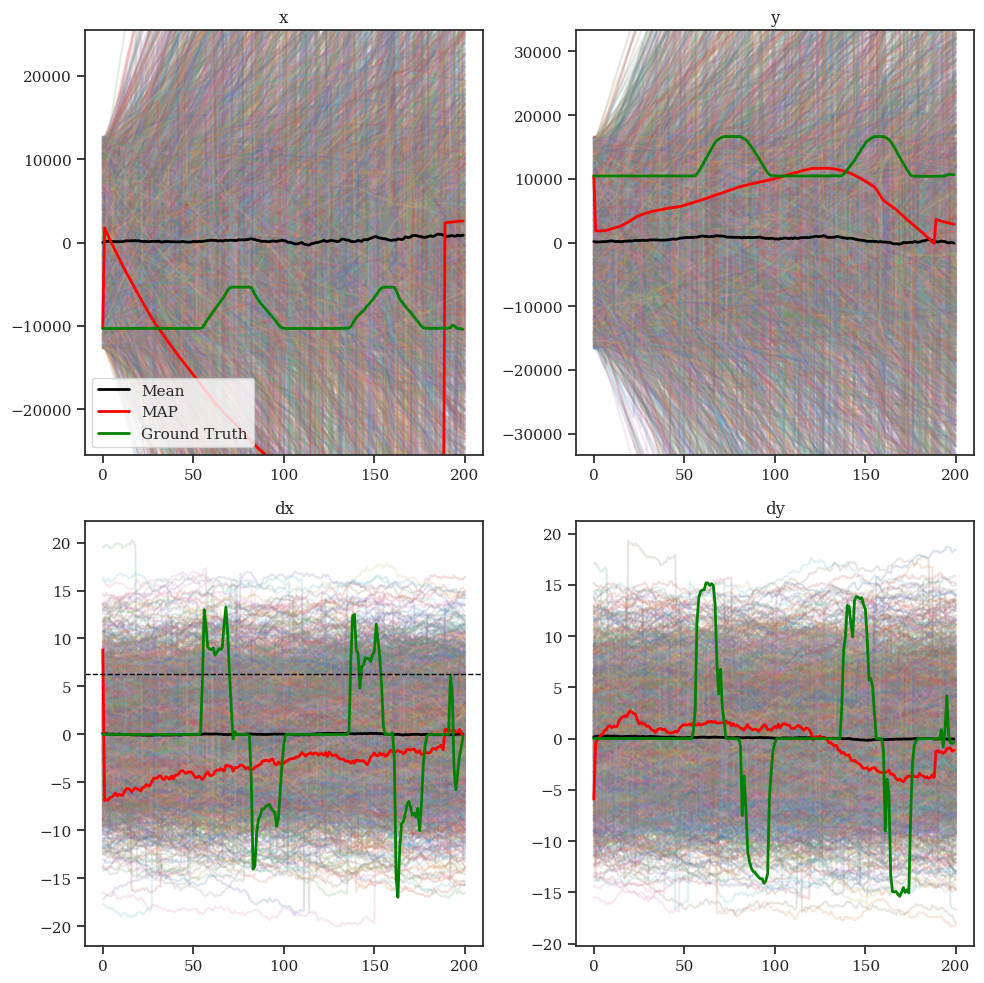

<Figure size 800x300 with 0 Axes>

In [220]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    if i >= result["trace_all_particles"].shape[2]:
        break
    ax.plot(result["trace_all_particles"][:, :, i], alpha=0.2)
    ax.plot(result["trace_state"][:, i], c="black", lw=2, label="Mean")
    ax.plot(result["trace_map_state"][:, i], c="red", lw=2, label="MAP")
    if i < result["ground_truth"].shape[1]:
        ax.plot(result["ground_truth"][:, i], c="green", lw=2, label="Ground Truth")
    ax.set_title(result["particle_filter"].column_names[i])

    # ax.axvline(result["deviate_from"], c="black", ls="--", lw=1)

    if i == 0:
        ax.set_ylim(-width, width)
    if i == 1:
        ax.set_ylim(-height, height)

    if i == 0:
        ax.legend()

axes[1, 0].axhline(2 * pi, c="black", ls="--", lw=1)

plt.tight_layout()
plt.show()
plt.clf()

## Particle filtering on our own

In [45]:
def run_experiment_pf1(
    data: ndarray,
    seed_value: int = 2024,
    constitutional_trust: float = 0.8,
    interpolator=None,
    full_inference: bool = False,
    use_constitution: bool = True,
) -> pd.DataFrame:
    def create_initial_particles(N: int) -> ndarray:
        return np.stack(
            [
                uniform(loc=-width / 2, scale=width).rvs(N),
                uniform(loc=-height / 2, scale=height).rvs(N),
                uniform(loc=0, scale=2 * pi).rvs(N),
                norm(loc=5, scale=3).rvs(N),
                # norm(loc=0, scale=typical_ship_speed).rvs(N),
                # norm(loc=0, scale=typical_ship_speed).rvs(N),
            ]
        ).T

    def predict(particles, dt=1.0):
        """move according to control input u (heading change, velocity)
        with noise Q (std heading change, std velocity)`"""

        particles = particles.copy()

        N = len(particles)

        # noise = standard_normal(N) * std[1]
        # particles[:, [0, 1]] += particles[:, [2, 3]] * dt + noise

        particles[:, 2] += standard_normal(N) * 0.05
        particles[:, 2] %= 2 * pi

        particles[:, 3] += standard_normal(N) * 0.3

        dist = particles[:, 3] * dt  # + (standard_normal(N) * std)

        # TODO: possibly also add noise to the heading
        particles[:, 0] += np.cos(particles[:, 2]) * dist
        particles[:, 1] += np.sin(particles[:, 2]) * dist

        return particles

    def update(
        particles,
        weights,
        z,
        R,
        use_constitution: bool = use_constitution,
        constitutional_trust: float = constitutional_trust,
    ):
        weights = weights.copy()

        positions = particles[:, :2]
        distance = np.linalg.norm(positions - z, axis=1)

        # Evaluate and RBF kernel
        weights *= np.exp(-(distance**2) / (2 * R**2))

        if use_constitution:
            if full_inference:
                # TODO this will likely use the wrong interpolator
                constitution = solve_at(promis, positions).data["v0"].to_numpy()
            else:
                constitution = interpolator(positions)[:, 0]
            weights *= constitutional_trust * constitution + (1 - constitutional_trust)

        weights += 1.0e-300  # avoid round-off to zero
        weights /= sum(weights)  # normalize

        return weights

    def estimate(particles, weights):
        """returns mean and variance of the weighted particles"""

        mean = np.average(particles, weights=weights, axis=0)
        var = np.average((particles - mean) ** 2, weights=weights, axis=0)
        return mean, var

    def neff(weights):
        return 1.0 / np.sum(np.square(weights))

    def resample_from_index(particles, weights, indexes):
        particles[:] = particles[indexes]
        weights.resize(len(particles))
        weights.fill(1.0 / len(weights))

    def run_pf1(
        N,
        data,
        sensor_std_err=5000,
        do_plot=False,
        plot_particles=False,
    ):
        if do_plot:
            plt.figure()

        # create particles
        particles = create_initial_particles(N)
        particles[:, 0] = norm(loc=data[0, 0], scale=1000).rvs(N)
        particles[:, 1] = norm(loc=data[0, 1], scale=1000).rvs(N)

        # create weights
        weights = np.ones(N) / N

        if do_plot and plot_particles:
            alpha = 0.20
            if N > 5000:
                alpha *= np.sqrt(5000) / np.sqrt(N)
            plt.scatter(particles[:, 0], particles[:, 1], alpha=alpha, color="g")

        weights_trace = []
        particle_trace = []
        xs = []
        for i, obs in enumerate(data):
            # move
            particles = predict(particles, dt=obs[4])

            # incorporate measurements
            weights = update(particles, weights, z=obs[:2], R=sensor_std_err)

            # resample if too few effective particles
            if neff(weights) < N / 2:
                indexes = systematic_resample(weights)
                resample_from_index(particles, weights, indexes)
                assert np.allclose(weights, 1 / N)
            mu, var = estimate(particles, weights)
            xs.append(mu)

            weights_trace.append(weights.copy())
            particle_trace.append(particles.copy())

            if do_plot:
                if plot_particles:
                    plt.scatter(
                        particles[:, 0], particles[:, 1], color="k", marker=",", s=0.5, alpha=0.2
                    )
                p1 = plt.scatter(obs[0], obs[1], marker="x", color="r")
                p2 = plt.scatter(mu[0], mu[1], marker="s", color="b")

            # print(f"Step {i+1}/{len(data)}")

        xs = np.array(xs)
        # plt.plot(xs[:, 0], xs[:, 1])
        if do_plot:
            plt.legend([p1, p2], ["Actual", "PF"], loc=4, numpoints=1)
        # plt.xlim(-width / 2, width / 2)
        # plt.ylim(-height / 2, height / 2)

        pos_error = np.linalg.norm(mu[:2] - data[:, :2], axis=1)
        # print("error, variance: ", pos_error.mean(), pos_error.var())
        all_error = np.linalg.norm(xs[:, :] - data[:, :4], axis=1)
        # print("all error, variance: ", all_error.mean(), all_error.var())

        if do_plot:
            plt.show()

        return {
            "particles": array(particle_trace),
            "weights": array(weights_trace),
            "estimates": xs,
            "pos_error": pos_error,
            "pos_error_mean": pos_error.mean(),
            "all_error": all_error,
            "all_error_mean": all_error.mean(),
            "truth": data,
        }

    data.loc[:, "RelativeTime"] = (
        data["BaseDateTime"] - data["BaseDateTime"].iloc[0]
    ).dt.total_seconds()
    assert data["RelativeTime"].is_monotonic_increasing

    ground_truth = stack(
        (data["East"], data["North"], deg2rad(data["COG"]), data["SOG"], data["RelativeTime"])
    ).T

    ground_truth[0, 4] = 0
    ground_truth[1:, 4] = ground_truth[1:, 4] - ground_truth[:-1, 4]

    seed(seed_value)
    return run_pf1(N=2000, data=ground_truth, plot_particles=True)


In [46]:
results = []

# df_for_type = df[df["VesselTypeName"].isin(relevant_vessel_types)]
df_for_type = df[df["VesselTypeName"].isin(landscapes.keys())]
df_for_type = df_for_type[df_for_type["MMSI"].isin(relevant_MMSIs)]

for tau in np.arange(0.0, 1.1, 0.1):
    for mmsi in relevant_MMSIs:
        for seed_value in [2024]:
            data = df_for_type[df_for_type["MMSI"] == mmsi].copy()
            if data.empty:
                continue
            vessel_type = data["VesselTypeName"].iloc[0]

            interpolator = interpolators[vessel_type]
            experiment_result = run_experiment_pf1(
                data,
                constitutional_trust=tau,
                seed_value=seed_value,
                interpolator=interpolator,
            )
            results.append(
                dict(
                    mmsi=mmsi,
                    type=vessel_type,
                    tau=tau,
                    seed=seed_value,
                    **experiment_result,
                )
            )
            print(
                f"Finished {mmsi} (progress: {len(results)}/{len(df_for_type['MMSI'].unique())*11})"
            )

df_results = pd.DataFrame(results)
df_results

Finished 636091125 (progress: 1/121)
Finished 372148000 (progress: 2/121)
Finished 538005359 (progress: 3/121)
Finished 636017103 (progress: 4/121)
Finished 636092678 (progress: 5/121)
Finished 636015956 (progress: 6/121)
Finished 636021004 (progress: 7/121)
Finished 256170000 (progress: 8/121)
Finished 636092711 (progress: 9/121)
Finished 636020360 (progress: 10/121)
Finished 353514000 (progress: 11/121)
Finished 636091125 (progress: 12/121)
Finished 372148000 (progress: 13/121)
Finished 538005359 (progress: 14/121)
Finished 636017103 (progress: 15/121)
Finished 636092678 (progress: 16/121)
Finished 636015956 (progress: 17/121)
Finished 636021004 (progress: 18/121)
Finished 256170000 (progress: 19/121)
Finished 636092711 (progress: 20/121)
Finished 636020360 (progress: 21/121)
Finished 353514000 (progress: 22/121)
Finished 636091125 (progress: 23/121)
Finished 372148000 (progress: 24/121)
Finished 538005359 (progress: 25/121)
Finished 636017103 (progress: 26/121)
Finished 636092678 (p

,mmsi,type,tau,seed,particles,weights,estimates,pos_error,pos_error_mean,all_error,all_error_mean,truth
0,636091125,Cargo,0.0,2024,"[[[13302.38259565403, -11780.733593322444, 1.3...","[[0.0005072512056533528, 0.0005026256090089099...","[[12603.727879181035, -12673.272793098778, 3.1...","[33707.034839875654, 33417.41118845816, 33161....",10495.249056,"[17.199316606407194, 298.74644359695566, 534.6...",1650.162747,"[[12608.469600050606, -12657.308433225147, 5.8..."
1,372148000,Cargo,0.0,2024,"[[[13415.592293260963, -12493.440544684272, 1....","[[0.0005072512056533528, 0.0005026256090089099...","[[12716.937576787985, -13385.979744460627, 3.1...","[44516.881909101525, 44288.519278109445, 44103...",26038.550891,"[16.97604083977871, 255.47800733094894, 435.27...",2122.992185,"[[12721.67929765754, -13370.015384586975, 6.05..."
2,538005359,Cargo,0.0,2024,"[[[-11801.5393431603, 11608.573990014898, 1.38...","[[0.0005072512056533528, 0.0005026256090089099...","[[-12500.194059633292, 10716.03479023855, 3.14...","[35827.220703277555, 35688.97890717707, 35601....",18434.174294,"[16.776574334755235, 204.06144494661623, 382.9...",1202.809413,"[[-12495.452338763724, 10731.999150112195, 1.5..."
3,636017103,Cargo,0.0,2024,"[[[13413.1029537595, -10526.865285208722, 1.38...","[[0.0005072512056533528, 0.0005026256090089099...","[[12714.448237286504, -11419.404484985047, 3.1...","[34979.49245171503, 34830.27974965187, 34672.2...",17445.768935,"[16.761293538498418, 226.96458592285975, 451.2...",1660.279350,"[[12719.189958156077, -11403.440125111425, 4.6..."
4,636092678,Cargo,0.0,2024,"[[[13321.208750042279, -10364.897026312727, 1....","[[0.0005072512056533528, 0.0005026256090089099...","[[12622.554033569279, -11257.436226089074, 3.1...","[34727.016075527106, 34503.207030967984, 34235...",15832.849228,"[16.808158354906364, 252.32662240979343, 528.3...",1418.422498,"[[12627.295754438856, -11241.47186621543, 4.98..."
...,...,...,...,...,...,...,...,...,...,...,...,...
116,636021004,Cargo,1.0,2024,"[[[-12860.93113326559, 10547.296643671625, 1.7...","[[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00...","[[-12277.944172560588, 10971.52482818557, 3.24...","[31049.022571121204, 30875.042556326705, 30755...",14428.623829,"[197.73597598724103, 134.51645906436727, 63.70...",4299.488406,"[[-12391.28569682304, 10809.558144994187, 1.52..."
117,256170000,Cargo,1.0,2024,"[[[-13026.826546160011, 10479.835851535167, 1....","[[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00...","[[-12581.499113386328, 10916.423876628714, 3.2...","[30767.17148708819, 30643.419722627823, 30511....",15565.836447,"[176.0386601135486, 265.6760960839942, 304.483...",3935.975789,"[[-12557.181109717461, 10742.097352857729, 1.6..."
118,636092711,Cargo,1.0,2024,"[[[-13137.581055299026, 10508.89595275234, 1.7...","[[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00...","[[-12737.621069676507, 10888.168751587178, 3.1...","[31223.164447888696, 31005.061377590977, 30858...",14410.851831,"[136.24040272605708, 345.8326647375064, 520.49...",6359.592781,"[[-12667.935618856476, 10771.157454074902, 1.6..."
119,636020360,Cargo,1.0,2024,"[[[-13127.41980408704, 10515.541505895331, 1.7...","[[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00...","[[-12711.424862411357, 10893.383106421143, 3.1...","[24582.916644963952, 24405.039644872246, 24270...",11276.962766,"[127.46503129093671, 296.5036202474298, 466.38...",9551.608275,"[[-12657.77436764449, 10777.803007217894, 1.65..."


In [47]:
len(data)

46

In [48]:
# before = monotonic()
# run_experiment_pf1(
#     data[:20],
#     constitutional_trust=0.5,
#     seed_value=2024,
#     interpolator=interpolator,
#     full_inference=False,
#     use_constitution=True,
# )
# after = monotonic()
# after - before

In [49]:
df_results.to_pickle("res-all-taus.pkl")

In [50]:
df_results = pd.read_pickle("res-all-taus.pkl")

In [51]:
df_results

,mmsi,type,tau,seed,particles,weights,estimates,pos_error,pos_error_mean,all_error,all_error_mean,truth
0,636091125,Cargo,0.0,2024,"[[[13302.38259565403, -11780.733593322444, 1.3...","[[0.0005072512056533528, 0.0005026256090089099...","[[12603.727879181035, -12673.272793098778, 3.1...","[33707.034839875654, 33417.41118845816, 33161....",10495.249056,"[17.199316606407194, 298.74644359695566, 534.6...",1650.162747,"[[12608.469600050606, -12657.308433225147, 5.8..."
1,372148000,Cargo,0.0,2024,"[[[13415.592293260963, -12493.440544684272, 1....","[[0.0005072512056533528, 0.0005026256090089099...","[[12716.937576787985, -13385.979744460627, 3.1...","[44516.881909101525, 44288.519278109445, 44103...",26038.550891,"[16.97604083977871, 255.47800733094894, 435.27...",2122.992185,"[[12721.67929765754, -13370.015384586975, 6.05..."
2,538005359,Cargo,0.0,2024,"[[[-11801.5393431603, 11608.573990014898, 1.38...","[[0.0005072512056533528, 0.0005026256090089099...","[[-12500.194059633292, 10716.03479023855, 3.14...","[35827.220703277555, 35688.97890717707, 35601....",18434.174294,"[16.776574334755235, 204.06144494661623, 382.9...",1202.809413,"[[-12495.452338763724, 10731.999150112195, 1.5..."
3,636017103,Cargo,0.0,2024,"[[[13413.1029537595, -10526.865285208722, 1.38...","[[0.0005072512056533528, 0.0005026256090089099...","[[12714.448237286504, -11419.404484985047, 3.1...","[34979.49245171503, 34830.27974965187, 34672.2...",17445.768935,"[16.761293538498418, 226.96458592285975, 451.2...",1660.279350,"[[12719.189958156077, -11403.440125111425, 4.6..."
4,636092678,Cargo,0.0,2024,"[[[13321.208750042279, -10364.897026312727, 1....","[[0.0005072512056533528, 0.0005026256090089099...","[[12622.554033569279, -11257.436226089074, 3.1...","[34727.016075527106, 34503.207030967984, 34235...",15832.849228,"[16.808158354906364, 252.32662240979343, 528.3...",1418.422498,"[[12627.295754438856, -11241.47186621543, 4.98..."
...,...,...,...,...,...,...,...,...,...,...,...,...
116,636021004,Cargo,1.0,2024,"[[[-12860.93113326559, 10547.296643671625, 1.7...","[[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00...","[[-12277.944172560588, 10971.52482818557, 3.24...","[31049.022571121204, 30875.042556326705, 30755...",14428.623829,"[197.73597598724103, 134.51645906436727, 63.70...",4299.488406,"[[-12391.28569682304, 10809.558144994187, 1.52..."
117,256170000,Cargo,1.0,2024,"[[[-13026.826546160011, 10479.835851535167, 1....","[[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00...","[[-12581.499113386328, 10916.423876628714, 3.2...","[30767.17148708819, 30643.419722627823, 30511....",15565.836447,"[176.0386601135486, 265.6760960839942, 304.483...",3935.975789,"[[-12557.181109717461, 10742.097352857729, 1.6..."
118,636092711,Cargo,1.0,2024,"[[[-13137.581055299026, 10508.89595275234, 1.7...","[[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00...","[[-12737.621069676507, 10888.168751587178, 3.1...","[31223.164447888696, 31005.061377590977, 30858...",14410.851831,"[136.24040272605708, 345.8326647375064, 520.49...",6359.592781,"[[-12667.935618856476, 10771.157454074902, 1.6..."
119,636020360,Cargo,1.0,2024,"[[[-13127.41980408704, 10515.541505895331, 1.7...","[[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00...","[[-12711.424862411357, 10893.383106421143, 3.1...","[24582.916644963952, 24405.039644872246, 24270...",11276.962766,"[127.46503129093671, 296.5036202474298, 466.38...",9551.608275,"[[-12657.77436764449, 10777.803007217894, 1.65..."


In [52]:
df_results[df_results["tau"] != 0.0]["pos_error_mean"]

11     11141.059302
12     11703.872421
13     18553.947674
14     16903.655695
15     15382.613539
           ...     
116    14428.623829
117    15565.836447
118    14410.851831
119    11276.962766
120     5681.041866
Name: pos_error_mean, Length: 110, dtype: float64

In [53]:
# with_benefit = df_results.groupby("mmsi").apply(
#     lambda group: group.assign(
#         benefit=(
#             group[group["tau"] != 0.0]["pos_error_mean"].min()
#             - group[group["tau"] == 0.0]["pos_error_mean"].item()
#         )
#     ),
#     include_groups=False,
# )

In [54]:
with_benefit = df_results.groupby("mmsi").apply(
    lambda group: group.copy()[
        (group["tau"] == 0.0)
        | (group["pos_error_mean"] == group[group["tau"] != 0.0]["pos_error_mean"].min())
    ]
    .assign(
        benefit=(
            group[group["tau"] != 0.0]["pos_error_mean"].min()
            - group[group["tau"] == 0.0]["pos_error_mean"].item()
        )
    )
    .sort_values("tau"),
    include_groups=False,
)

In [55]:
# with_benefit = with_benefit[
#     (with_benefit["benefit"] > max(with_benefit["benefit"].quantile(0.6).item(), 0))
# ]
with_benefit

type  tau  seed  \
mmsi                              
256170000 7    Cargo  0.0  2024   
          117  Cargo  1.0  2024   
353514000 10   Cargo  0.0  2024   
          109  Cargo  0.9  2024   
372148000 1    Cargo  0.0  2024   
          12   Cargo  0.1  2024   
538005359 2    Cargo  0.0  2024   
          112  Cargo  1.0  2024   
636015956 5    Cargo  0.0  2024   
          115  Cargo  1.0  2024   
636017103 3    Cargo  0.0  2024   
          113  Cargo  1.0  2024   
636020360 9    Cargo  0.0  2024   
          119  Cargo  1.0  2024   
636021004 6    Cargo  0.0  2024   
          116  Cargo  1.0  2024   
636091125 0    Cargo  0.0  2024   
          33   Cargo  0.3  2024   
636092678 4    Cargo  0.0  2024   
          114  Cargo  1.0  2024   
636092711 8    Cargo  0.0  2024   
          118  Cargo  1.0  2024   

                                                       particles  \
mmsi                                                               
256170000 7    [[[-11863.268114114038, 11618.672192760432, 1....   
          117  [[[-13026.826546160011, 10479.835851535167, 1....   
353514000 10   [[[-5529.058807165844, 210.6761321371324, 1.38...   
          109  [[[-5529.058807165844, 210.6761321371324, 1.38...   
372148000 1    [[[13415.592293260963, -12493.440544684272, 1....   
          12   [[[13415.592293260963, -12493.440544684272, 1....   
538005359 2    [[[-11801.5393431603, 11608.573990014898, 1.38...   
          112  [[[-12965.097775206274, 10469.737648789633, 1....   
636015956 5    [[[-11985.014579804387, 11649.97196792854, 1.3...   
          115  [[[-13148.57301185036, 10511.135626703275, 1.7...   
636017103 3    [[[13413.1029537595, -10526.865285208722, 1.38...   
          113  [[[13413.1029537595, -10526.865285208722, 1.38...   
636020360 9    [[[-11963.861372041067, 11654.377847120597, 1....   
          119  [[[-13127.41980408704, 10515.541505895331, 1.7...   
636021004 6    [[[-11697.372701219618, 11686.13298489689, 1.3...   
          116  [[[-12860.93113326559, 10547.296643671625, 1.7...   
636091125 0    [[[13302.38259565403, -11780.733593322444, 1.3...   
          33   [[[13302.38259565403, -11780.733593322444, 1.3...   
636092678 4    [[[13321.208750042279, -10364.897026312727, 1....   
          114  [[[13321.208750042279, -10364.897026312727, 1....   
636092711 8    [[[-11974.022623253053, 11647.732293977606, 1....   
          118  [[[-13137.581055299026, 10508.89595275234, 1.7...   

                                                         weights  \
mmsi                                                               
256170000 7    [[0.0005072512056533528, 0.0005026256090089099...   
          117  [[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00...   
353514000 10   [[0.0005072512056533528, 0.0005026256090089099...   
          109  [[7.434415008868054e-05, 0.0007035123347825723...   
372148000 1    [[0.0005072512056533528, 0.0005026256090089099...   
          12   [[0.0005082740903442278, 0.0005036391660689364...   
538005359 2    [[0.0005072512056533528, 0.0005026256090089099...   
          112  [[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00...   
636015956 5    [[0.0005072512056533528, 0.0005026256090089099...   
          115  [[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00...   
636017103 3    [[0.0005072512056533528, 0.0005026256090089099...   
          113  [[0.0005958389099787763, 1.2861502638943393e-3...   
636020360 9    [[0.0005072512056533528, 0.0005026256090089099...   
          119  [[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00...   
636021004 6    [[0.0005072512056533528, 0.0005026256090089099...   
          116  [[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00...   
636091125 0    [[0.0005072512056533528, 0.0005026256090089099...   
          33   [[0.0005178839091756349, 0.0005131613534758247...   
636092678 4    [[0.0005072512056533528, 0.0005026256090089099...   
          114  [[0.0006171536294261324, 1.3321592297120087e-3...   
636092711 8    [[0.0005072512056533528, 0.0005

In [56]:
results = with_benefit.loc[[with_benefit.index.get_level_values(0)[::2][10]]]
results

type  tau  seed  \
mmsi                              
636092711 8    Cargo  0.0  2024   
          118  Cargo  1.0  2024   

                                                       particles  \
mmsi                                                               
636092711 8    [[[-11974.022623253053, 11647.732293977606, 1....   
          118  [[[-13137.581055299026, 10508.89595275234, 1.7...   

                                                         weights  \
mmsi                                                               
636092711 8    [[0.0005072512056533528, 0.0005026256090089099...   
          118  [[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00...   

                                                       estimates  \
mmsi                                                               
636092711 8    [[-12672.677339726024, 10755.19309420127, 3.14...   
          118  [[-12737.621069676507, 10888.168751587178, 3.1...   

                                                       pos_error  \
mmsi                                                               
636092711 8    [37781.0400233363, 37570.47849907499, 37432.30...   
          118  [31223.164447888696, 31005.061377590977, 30858...   

               pos_error_mean  \
mmsi                            
636092711 8      19666.195584   
          118    14410.851831   

                                                       all_error  \
mmsi                                                               
636092711 8    [17.045277331937026, 282.2285976440942, 523.73...   
          118  [136.24040272605708, 345.8326647375064, 520.49...   

               all_error_mean  \
mmsi                            
636092711 8       1658.165235   
          118     6359.592781   

                                                           truth      benefit  
mmsi                                                                           
636092711 8    [[-12667.935618856476, 10771.157454074902, 1.6... -5255.343752  
          118  [[-12667.935618856476, 10771.157454074902, 1.6... -5255.343752

In [57]:
result_pf, result_cofi = results.iloc[0], results.iloc[1]
result = result_cofi

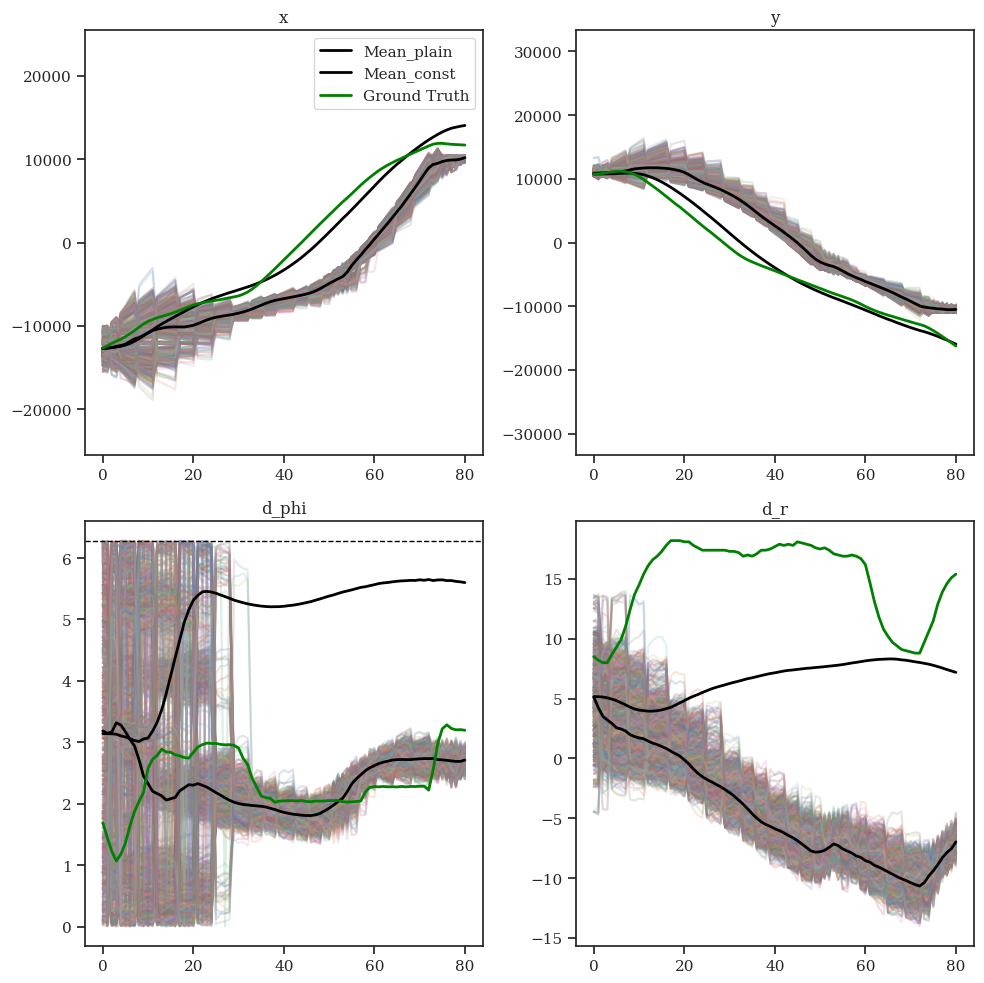

<Figure size 800x300 with 0 Axes>

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

columns = ["x", "y", "d_phi", "d_r"]

# time_start = 0
# time_end = 400

for i, ax in enumerate(axes.flatten()):
    if i >= result["particles"].shape[2]:
        break
    ax.plot(result["particles"][:, :, i], alpha=0.2)

    if i < result_pf["estimates"].shape[1]:
        ax.plot(result_pf["estimates"][:, i], c="black", lw=2, label="Mean_plain")
    if i < result_cofi["estimates"].shape[1]:
        ax.plot(result_cofi["estimates"][:, i], c="black", lw=2, label="Mean_const")

    if i < result["truth"].shape[1]:
        ax.plot(result["truth"][:, i], c="green", lw=2, label="Ground Truth")
    ax.set_title(columns[i])

    # ax.axvline(result["deviate_from"], c="black", ls="--", lw=1)

    if i == 0:
        ax.set_ylim(-width, width)
    if i == 1:
        ax.set_ylim(-height, height)

    if i == 0:
        ax.legend()

axes[1, 0].axhline(2 * pi, c="black", ls="--", lw=1)

plt.tight_layout()
plt.show()
plt.clf()

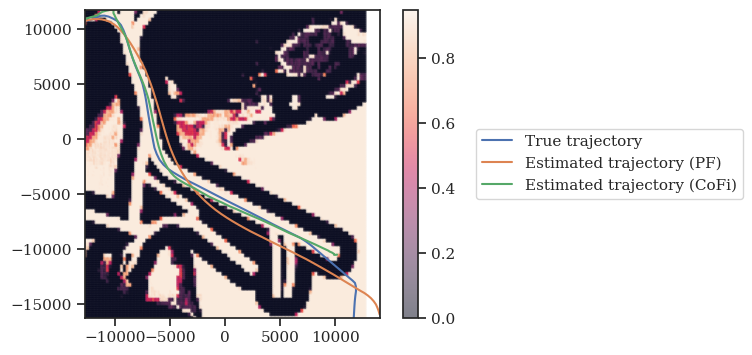

In [59]:
plt.figure(figsize=(6, 4))
landscape.scatter(s=2, alpha=0.5)
plot_trajectories(result_pf["truth"][:, :2], label="True trajectory")
plot_trajectories(result_pf["estimates"][:, :2], label="Estimated trajectory (PF)")
plot_trajectories(result_cofi["estimates"][:, :2], label="Estimated trajectory (CoFi)")

# show_n_particles = 10
# plot_trajectories(trace_all_particles[:, :show_n_particles, :2].swapaxes(1, 0), label=None)

scale = 1.5
# plt.gca().set_xlim(-width / 2 * scale, width / 2 * scale)
# plt.gca().set_ylim(-height / 2 * scale, height / 2 * scale)

# plt.gca().set_xlim(-15_000, -2_000)
# plt.gca().set_ylim(8_000, 18_000)

all_coords = np.concatenate(
    [result_pf["truth"][:, :2], result_pf["estimates"][:, :2], result_cofi["estimates"][:, :2]]
)
plt.gca().set_xlim(all_coords[:, 0].min(), all_coords[:, 0].max())
plt.gca().set_ylim(all_coords[:, 1].min(), all_coords[:, 1].max())

# Move legend to the right of the plot
plt.legend()
move_legend(plt.gca(), loc="center left", bbox_to_anchor=(1.3, 0.5))

plt.colorbar()
pass

In [82]:
def cartesian_to_polar(coords: ndarray) -> ndarray:
    collection = CartesianCollection(origin=origin, dimensions=1)
    collection.append_with_default(coords, np.nan)
    return collection.to_polar().coordinates()


def make_line_string(cartesian_coords: ndarray) -> str:
    return json.dumps(
        {
            "type": "LineString",
            "coordinates": cartesian_to_polar(cartesian_coords).tolist(),
        }
    )


start_date = "2023-08-01 0:0:00"
date_format = "%Y-%m-%d %X"


def make_route_points(cartesian_coords: ndarray) -> str:
    """

    Args:
        cartesian_coords: Shape (T, 2)
    """
    return json.dumps(
        {
            "type": "FeatureCollection",
            "features": [
                {
                    "type": "Feature",
                    "geometry": {
                        "type": "Point",
                        "coordinates": coord.tolist(),
                    },
                    "properties": {
                        "timestamp": time,
                    },
                }
                for coord, time in zip(
                    cartesian_to_polar(cartesian_coords),
                    pd.date_range(start=start_date, periods=cartesian_coords.shape[0]).strftime(
                        date_format
                    ),
                )
            ],
        }
    )


def make_particles(cartesian_coords: ndarray, weights: ndarray) -> str:
    """

    Args:
        cartesian_coords: Shape (T, N, 2)
        weights: Shape (T, N)
    """
    return json.dumps(
        {
            "type": "FeatureCollection",
            "features": [
                {
                    "type": "Feature",
                    "geometry": {
                        "type": "Point",
                        "coordinates": coord.tolist(),
                    },
                    "properties": {
                        "timestamp": time,
                        "weight": weight,
                    },
                }
                for coords_t, weights_t, time in zip(
                    cartesian_coords,
                    weights,
                    pd.date_range(start=start_date, periods=cartesian_coords.shape[0]).strftime(
                        date_format
                    ),
                )
                for coord, weight in zip(
                    cartesian_to_polar(coords_t),
                    weights_t.tolist(),
                )
            ],
        }
    )

In [83]:
result_pf

type                                                          Cargo
tau                                                             0.0
seed                                                           2024
particles         [[[-11974.022623253053, 11647.732293977606, 1....
weights           [[0.0005072512056533528, 0.0005026256090089099...
estimates         [[-12672.677339726024, 10755.19309420127, 3.14...
pos_error         [37781.0400233363, 37570.47849907499, 37432.30...
pos_error_mean                                         19666.195584
all_error         [17.045277331937026, 282.2285976440942, 523.73...
all_error_mean                                          1658.165235
truth             [[-12667.935618856476, 10771.157454074902, 1.6...
benefit                                                -5255.343752
Name: (636092711, 8), dtype: object

In [84]:
result_pf["weights"].shape

(81, 2000)

In [94]:
subsample_particles = 4
map = KeplerGl(
    data={
        "True Trajectory Track": make_line_string(result_pf["truth"][:, :2]),
        "True Trajectory": make_route_points(result_pf["truth"][:, :2]),
        #
        "Estimated Trajectory (CoFi) Track": make_line_string(result_cofi["estimates"][:, :2]),
        "Estimated Trajectory (CoFi)": make_route_points(result_cofi["estimates"][:, :2]),
        #
        "Estimated Trajectory (PF) Track": make_line_string(result_pf["estimates"][:, :2]),
        "Estimated Trajectory (PF)": make_route_points(result_pf["estimates"][:, :2]),
        #
        "Particles (PF)": make_particles(
            result_pf["particles"][:, :subsample_particles, :2],
            weights=result_pf["weights"][:, :subsample_particles],
        ),
        "Particles (CoFi)": make_particles(
            result_cofi["particles"][:, :subsample_particles, :2],
            weights=result_cofi["weights"][:, :subsample_particles],
        ),
    },
    config={
        "version": "v1",
        "config": {
            "mapState": {
                "latitude": cartesian_to_polar(all_coords)[:, 1].mean(),
                "longitude": cartesian_to_polar(all_coords)[:, 0].mean(),
                "zoom": 11,
            },
            "visState": {
                "filters": [
                    {
                        "dataId": [data_field],
                        "id": f"94q7ipgwi-{data_field}",
                        "name": ["timestamp"],
                        "type": "DateTime",
                        "yAxis": None,
                        "speed": 0.2,
                    }
                    for data_field in [
                        "True Trajectory",
                        "Estimated Trajectory (CoFi)",
                        "Estimated Trajectory (PF)",
                        "Particles (PF)",
                        "Particles (CoFi)",
                    ]
                ]
            },
        },
    },
)
map.save_to_html(file_name="debug_keplergl.html")
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to debug_keplergl.html!


KeplerGl(config={'version': 'v1', 'config': {'mapState': {'latitude': np.float64(40.5402913592116), 'longitude…

In [104]:
res_ = []
for vessel_type in interpolators:
    df_ = df[df["VesselTypeName"] == vessel_type]
    points = df_[["East", "North"]].values
    c = interpolators[vessel_type](points)
    for value in c:
        res_.append(
            {
                "Vessel Type": vessel_type,
                "Constitutional": value.item(),
            }
        )

res_df = pd.DataFrame(res_)
res_df

,Vessel Type,Constitutional
0,Cargo,0.9215
1,Cargo,0.1805
2,Cargo,0.9500
3,Cargo,0.9500
4,Cargo,0.7315
...,...,...
1069,Cargo,0.9500
1070,Cargo,0.9500
1071,Cargo,0.9500
1072,Cargo,0.9500


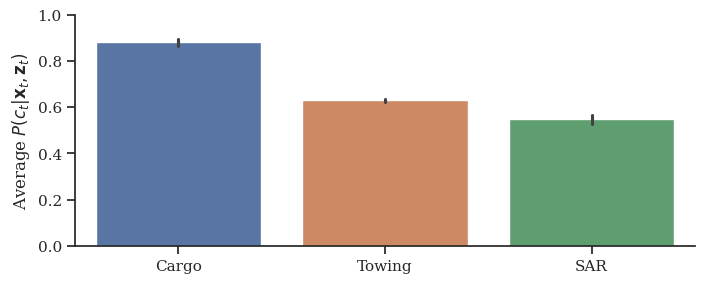

In [256]:
sns.barplot(
    data=res_df.replace({"Vessel Type": {"Search and rescue vessels": "SAR"}}),
    x="Vessel Type",
    y="Constitutional",
    hue="Vessel Type",
    order=["Cargo", "Towing", "SAR"],
    hue_order=["Cargo", "Towing", "SAR"],
)
sns.despine()
plt.ylabel(r"Average $P(c_t | \mathbf{x}_t, \mathbf{z}_t)$")
plt.xlabel("")
plt.ylim(0, 1)
plt.savefig(Path(".") / "plots" / f"ais-{setting}-constitution.pdf", bbox_inches="tight")
pass

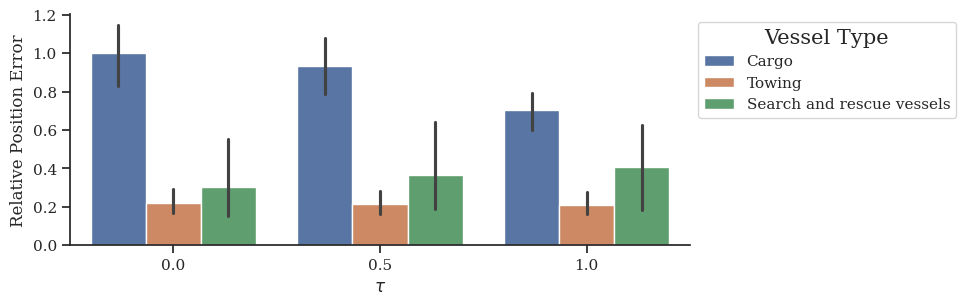

In [184]:
df_ = df_results.rename(
    columns={
        "type": "Vessel Type",
        "tau": r"$\tau$",
        "pos_error_mean": "Relative Position Error",
    }
)
df_ = df_[df_["Relative Position Error"] < 100_000]
reference_error = df_[(df_["Vessel Type"] == "Cargo") & (df_[r"$\tau$"] == 0.0)][
    "Relative Position Error"
].mean()
df_["Relative Position Error"] /= reference_error
sns.barplot(
    x=r"$\tau$",
    y="Relative Position Error",
    hue="Vessel Type",
    data=df_[df_[r"$\tau$"].isin([0.0, 0.5, 1.0])],
    hue_order=["Cargo", "Towing", "Search and rescue vessels"],
)

# mvoe the legend outside
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))

sns.despine()

plt.savefig(Path(".") / "plots" / "relative_position_error.pdf", bbox_inches="tight")
pass

<Axes: xlabel='tau', ylabel='all_error_mean'>

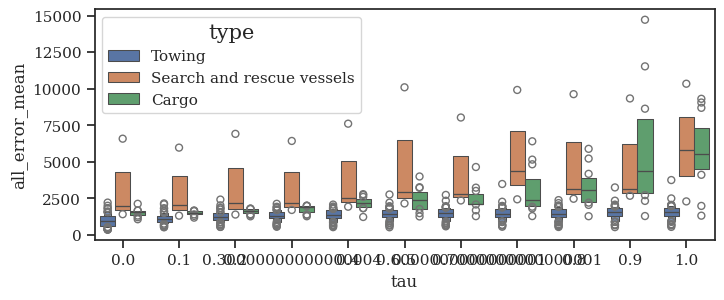

In [151]:
# sns.barplot(x="tau", y="all_error_mean", hue="type", data=df_results)
sns.boxenplot(
    x="tau",
    y="all_error_mean",
    hue="type",
    data=df_results,
    # width_method="linear",
)
pass

(0.0, 30000.0)

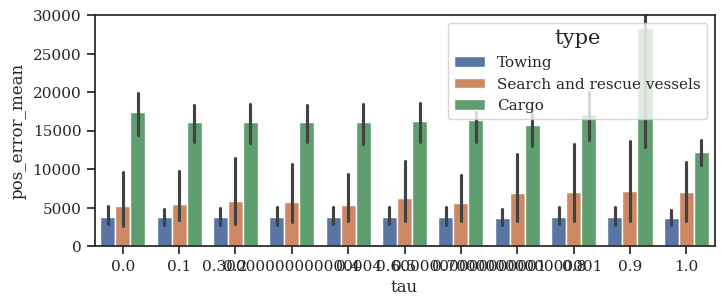

In [148]:
sns.barplot(x="tau", y="pos_error_mean", hue="type", data=df_results)
plt.ylim(None, 30_000)

In [83]:
# Groub by MMSI and trhen take the tau with the lowest error each
# df_results[["mmsi", "pos_error_mean"]].groupby("mmsi").apply(
#     lambda x: x.sort_values("tau").loc[x["pos_error_mean"].idxmin()]
# )
res = []
for mmis in df_results["mmsi"].unique():
    df_ = df_results[df_results["mmsi"] == mmis]
    # sort by tau
    df_ = df_.sort_values("pos_error_mean")
    res.append((df_["type"].iloc[0], df_["tau"].iloc[0]))

res = pd.DataFrame(res, columns=["Vessel Type", r"$\tau$"])
# Rname Search and rescue vessels to SAR
res["Vessel Type"] = res["Vessel Type"].replace("Search and rescue vessels", "SAR")
res

,Vessel Type,$\tau$
0,Towing,0.8
1,Towing,0.8
2,Towing,1.0
3,Towing,0.4
4,SAR,0.0
...,...,...
62,Towing,0.8
63,Towing,0.0
64,Towing,0.0
65,Towing,0.0


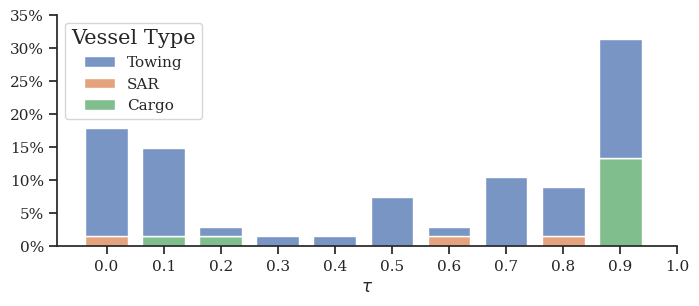

In [147]:
r_ = res.copy()

# r_["Vessel Type"] = "All"
# res_ = pd.concat([res, r_], axis=0)
# res_.sort_values("Vessel Type", inplace=True)

sns.histplot(
    r_,
    x=r"$\tau$",
    hue="Vessel Type",
    multiple="stack",
    bins=10,
    stat="percent",
    shrink=0.75,
    # palette="colorblind",
)

plt.ylabel("")
plt.yticks(plt.yticks()[0], [f"{i.get_text()}%" for i in plt.yticks()[1]])
sns.despine()

# Fix the placmenet of the x-axis
plt.xticks(np.arange(0, 1.1, 0.1) + 0.05, [f"{i:.1f}" for i in np.arange(0, 1.1, 0.1)])

plt.savefig(Path(".") / "plots" / "tau-distribution.pdf", bbox_inches="tight")

pass

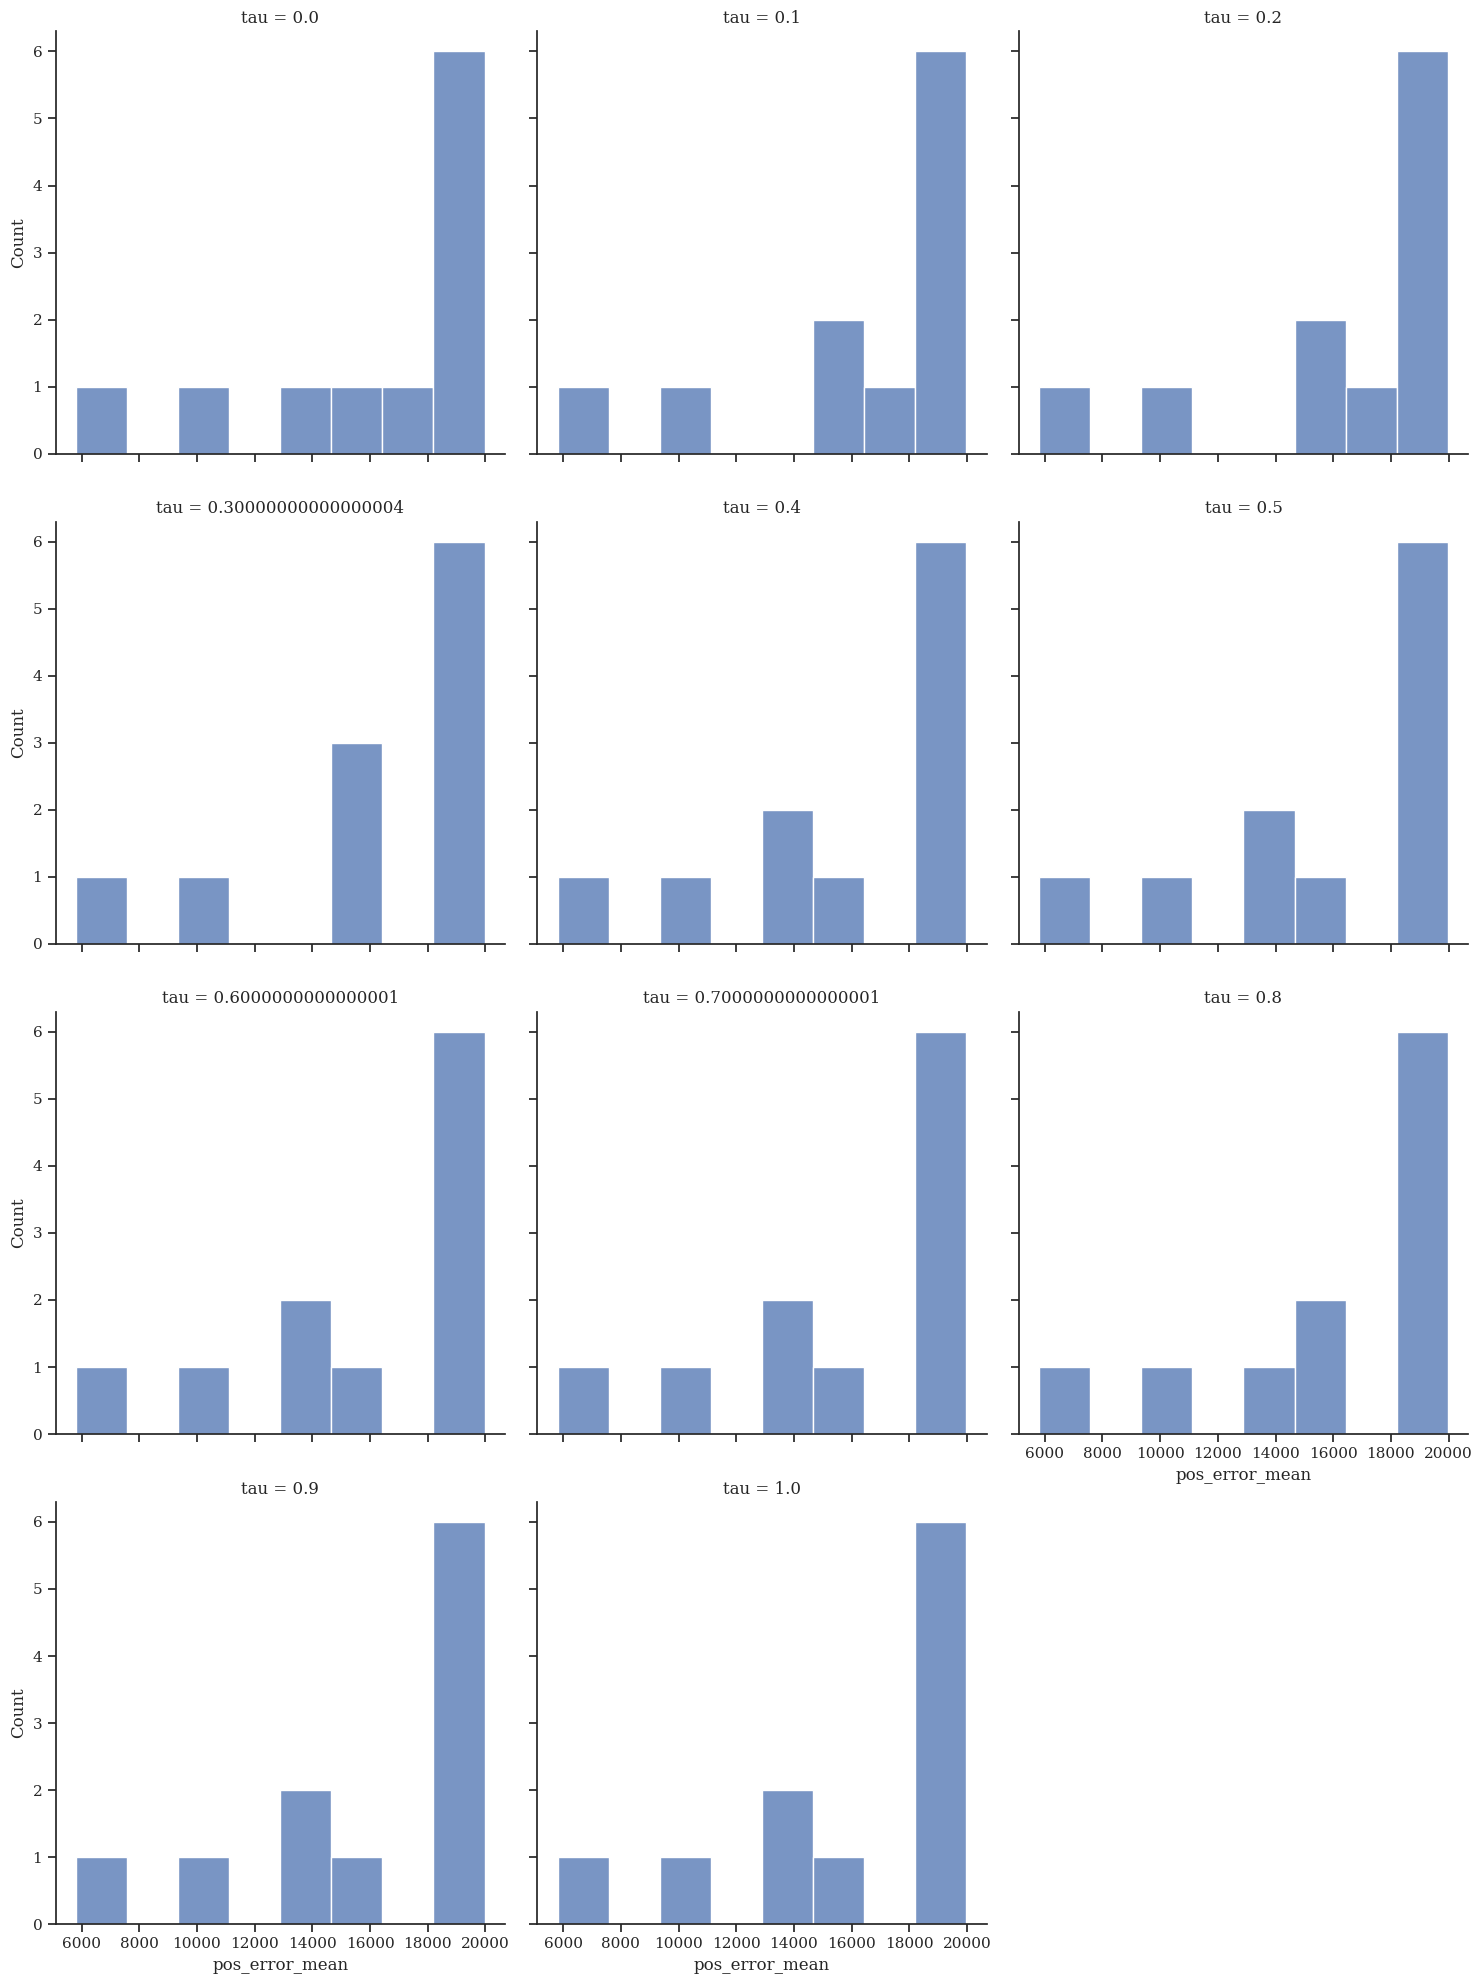

In [302]:
sns.displot(
    df_results,
    x="pos_error_mean",  # or "all_error"
    col="tau",
    col_wrap=3,
    facet_kws=dict(margin_titles=True),
)

## Older stuff

In [116]:
results = []

df_for_type = df[df["VesselTypeName"].isin(["Cargo", "Cargo hazardous"])]

for tau in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    for mmsi in relevant_MMSIs:
        for seed_value in [2024]:
            data = df_for_type[df_for_type["MMSI"] == mmsi].copy()
            if data.empty:
                continue
            vessel_type = data["VesselTypeName"].iloc[0]
            experiment_result = run_experiment(
                data, constitutional_trust=tau, seed_value=seed_value, verbose=False
            )
            results.append(
                dict(
                    mmsi=mmsi,
                    type=vessel_type,
                    tau=tau,
                    seed=seed_value,
                    mean_mean=np.mean(experiment_result["position_accuracy_mean"]),
                    mean_std=np.std(experiment_result["position_accuracy_mean"]),
                    map_mean=np.mean(experiment_result["position_accuracy_map"]),
                    map_std=np.std(experiment_result["position_accuracy_map"]),
                    **experiment_result,
                )
            )
            print(f"Finished {mmsi} (progress: {len(results)}/{len(df_for_type['MMSI'].unique())})")

df_results = pd.DataFrame(results)
df_results

Finished 636091125 (progress: 1/1074)
Finished 372148000 (progress: 2/1074)
Finished 538005359 (progress: 3/1074)
Finished 636017103 (progress: 4/1074)
Finished 636092678 (progress: 5/1074)
Finished 636015956 (progress: 6/1074)
Finished 636021004 (progress: 7/1074)
Finished 256170000 (progress: 8/1074)
Finished 636092711 (progress: 9/1074)
Finished 636020360 (progress: 10/1074)
Finished 353514000 (progress: 11/1074)
Finished 636091125 (progress: 12/1074)
Finished 372148000 (progress: 13/1074)
Finished 538005359 (progress: 14/1074)
Finished 636017103 (progress: 15/1074)
Finished 636092678 (progress: 16/1074)
Finished 636015956 (progress: 17/1074)
Finished 636021004 (progress: 18/1074)
Finished 256170000 (progress: 19/1074)
Finished 636092711 (progress: 20/1074)
Finished 636020360 (progress: 21/1074)
Finished 353514000 (progress: 22/1074)
Finished 636091125 (progress: 23/1074)
Finished 372148000 (progress: 24/1074)
Finished 538005359 (progress: 25/1074)
Finished 636017103 (progress: 26/1

,mmsi,type,tau,seed,mean_mean,mean_std,map_mean,map_std,ground_truth,deviate_from,...,trace_map_state,trace_hypotheses,trace_map_hypotheses,trace_weights,trace_weights_unnormalized,trace_weight_e1,trace_weight_e2,particle_filter,position_accuracy_mean,position_accuracy_map
0,636091125,Cargo,0.0,2024,43380.199996,18303.870316,45683.633637,14883.384582,"[[12608.469600050606, -12657.308433225147, 5.8...",148,...,"[[12059.069868357594, -13245.908021410387, 5.4...","[[209.50343541994934, 45.61867514066415, 3.189...","[[12059.069868357594, -13245.908021410387, 5.4...","[[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0....","[[1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.574003408292641e-08, 1.2660606064213618e-0...",<promis.estimators.filters.particle.ParticleFi...,"[12314.533276359602, 11414.959290238608, 5307....","[1118.832694006332, 968.1990404142078, 760.027..."
1,372148000,Cargo,0.0,2024,29790.842992,96360.556752,37507.554775,122447.401760,"[[12721.67929765754, -13370.015384586975, 6.05...",105,...,"[[2426.094848358818, -7619.58329601293, 3.3093...","[[163.00057871069293, 96.8165971291947, 3.1820...","[[2426.094848358818, -7619.58329601293, 3.3093...","[[0.0009999999999999998, 0.0009999999999999998...","[[1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[4.22915720391813e-18, 1.7859651609168418e-11...",<promis.estimators.filters.particle.ParticleFi...,"[16286.475084199667, 16072.302955629188, 15872...","[14231.239615857936, 14820.100053536607, 15543..."
2,538005359,Cargo,0.0,2024,6284.214965,4586.733049,18100.276712,19070.418781,"[[-12495.452338763724, 10731.999150112195, 1.5...",98,...,"[[2426.094848358818, -7619.58329601293, 3.3093...","[[163.00057871069293, 96.8165971291947, 3.1820...","[[2426.094848358818, -7619.58329601293, 3.3093...","[[0.0009999999999999998, 0.0009999999999999998...","[[1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e...","[[0.0, 0.0, 0.0, 0.0, 6.54664850927395e-259, 0...","[[3.984289794609825e-20, 2.2332635020824793e-0...",<promis.estimators.filters.particle.ParticleFi...,"[2881.354675613523, 2601.234291883836, 2339.83...","[564.3654672488343, 11541.585471411816, 11448...."
3,636017103,Cargo,0.0,2024,27572.782082,18428.711750,20119.710003,11835.356289,"[[12719.189958156077, -11403.440125111425, 4.6...",89,...,"[[2426.094848358818, -7619.58329601293, 3.3093...","[[163.00057871069293, 96.8165971291947, 3.1820...","[[2426.094848358818, -7619.58329601293, 3.3093...","[[0.0009999999999999998, 0.0009999999999999998...","[[1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[6.804263042793148e-21, 2.487886836942742e-10...",<promis.estimators.filters.particle.ParticleFi...,"[15268.096972215779, 14995.477095723958, 14695...","[13255.935166855441, 13825.530254177418, 14702..."
4,636092678,Cargo,0.0,2024,5618.300331,3472.345827,11301.245356,8749.671949,"[[12627.295754438856, -11241.47186621543, 4.98...",82,...,"[[2426.094848358818, -7619.58329601293, 3.3093...","[[163.00057871069293, 96.8165971291947, 3.1820...","[[2426.094848358818, -7619.58329601293, 3.3093...","[[0.0009999999999999998, 0.0009999999999999998...","[[1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[3.505855919285488e-19, 1.8278492419731392e-1...",<promis.estimators.filters.particle.ParticleFi...,"[1279.1610502873627, 1178.6504965125932, 1084....","[915.7506650669197, 803.1532545158126, 825.117..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,636021004,Cargo,1.0,2024,2925.304180,3273.471717,3772.048363,4401.445551,"[[-12391.28569682304, 10809.558144994187, 1.52...",74,...,"[[2426.094848358818, -7619.58329601293, 3.3093...","[[163.00057871069293, 96.8165971291947, 3.1820...","[[2426.094848358818, -7619.58329601293, 3.3093...","[[0.0009999999999999998, 0.0009999999999999998...","[[1e-06, 1e-06, 

In [103]:
sns.displot(
    df_results,  # [["map_mean", "tau"]],
    x="mean_mean",
    col="tau",
    col_wrap=3,
    facet_kws=dict(margin_titles=True),
)

ValueError: Could not interpret value `mean_mean` for `x`. An entry with this name does not appear in `data`.

In [104]:
g = sns.catplot(
    data=df_results,
    kind="bar",
    x="tau",
    y="mean_mean",
    # hue="sex",
    errorbar="sd",
    alpha=0.6,
    height=6,
)

ValueError: Could not interpret value `mean_mean` for `y`. An entry with this name does not appear in `data`.

In [65]:
# Visualize the weights of the particles
# plt.plot(result["trace_weight_e1"])
# pass

In [66]:
# plt.plot(result["trace_weight_e2"])
# pass

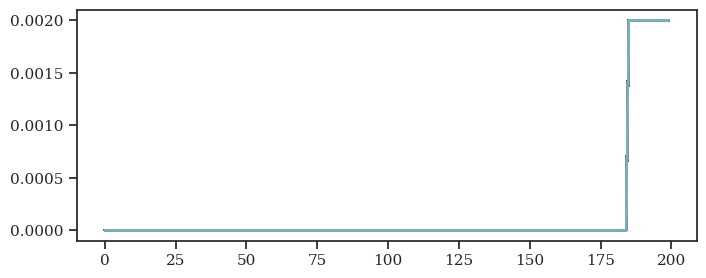

In [179]:
# Visualize the weights of the particles
# plt.plot(result["trace_weights"])
plt.plot(result["trace_weights_unnormalized"])
pass

In [180]:
import numpy as np

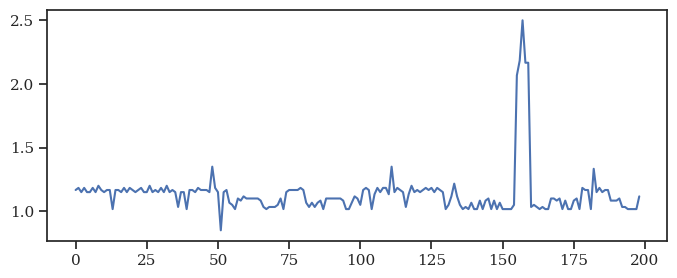

In [181]:
# plt.plot(result["trace_time"])
plt.plot(np.diff(result["trace_time"]) / 60)
pass

In [95]:
# plt.hist(trace_all_particles[20, :, 2].ravel(), bins=100)
# pass

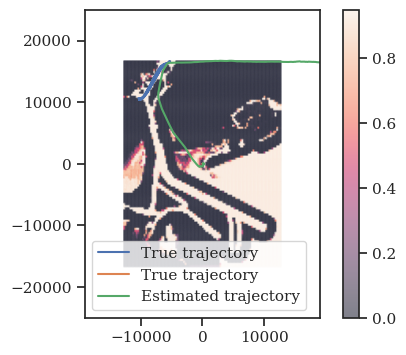

In [146]:
plt.figure(figsize=(6, 4))
landscape.scatter(s=0.1, alpha=0.5)
plot_trajectories(result["ground_truth"], label="True trajectory")
plot_trajectories(result["trace_state"][:, :2], label="Estimated trajectory")

# show_n_particles = 10
# plot_trajectories(trace_all_particles[:, :show_n_particles, :2].swapaxes(1, 0), label=None)

scale = 1.5
plt.gca().set_xlim(-width / 2 * scale, width / 2 * scale)
plt.gca().set_ylim(-height / 2 * scale, height / 2 * scale)

plt.colorbar()
plt.legend()
pass

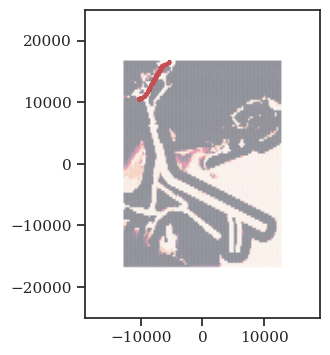

In [133]:
plt.figure(figsize=(6, 4))
plt.gca().set_aspect("equal")
landscape.scatter(s=0.1, alpha=0.2)
# plt.scatter(*result["trace_all_particles"][:, :, :2][50, ...].T, c="r", s=1)
plt.scatter(*debug_df[["East", "North"]].values.T, c="r", s=1)
plt.xlim(-width / 2 * scale, width / 2 * scale)
plt.ylim(-height / 2 * scale, height / 2 * scale)

pass

In [ ]:
index = 30

plt.gca().set_aspect("equal")

# draw a box around the frame (-1500, -1500) to (1500, 1500)
plt.plot(
    [-width / 2, width / 2, width / 2, -width / 2, -width / 2],
    [-height / 2, -height / 2, height / 2, height / 2, -height / 2],
    "k-",
    alpha=0.3,
    label="Frame",
)

plot_trajectories(result["ground_truth"], label="True trajectory", color="k", alpha=0.3)

plt.hist2d(
    *result["trace_all_particles"][index, :, :2].T,
    bins=50,
    range=[[-width / 2 * scale, width / 2 * scale], [-height / 2 * scale, height / 2 * scale]],
    cmap="Oranges",
)

if index > 0:
    # Plot the ship position and position estimate at that time point
    plt.gca().plot(
        *result["ground_truth"][index - 1],
        marker=ship_marker,
        markersize=14,
        label="True position",
        c="k",
        alpha=0.5,
    )
    plt.gca().plot(
        *result["trace_state"][index - 1, :2],
        marker=ship_marker,
        markersize=14,
        label="Estimated position",
        c="b",
    )


plt.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
pass

In [290]:
res_starmap = pd.DataFrame(
    [
        dict(name=r"StarMap ($100 \times x 100$)", time=640.4149391481187),
        dict(name=r"StarMap ($100 \times x 100$)", time=627.0258562378585),
        dict(name=r"StarMap ($100 \times x 100$)", time=624.6253640819341),
        #
        dict(name=r"StarMap ($50 \times 50$)", time=495.63382973195985),
        dict(name=r"StarMap ($50 \times 50$)", time=487.28305474994704),
        dict(name=r"StarMap ($50 \times 50$)", time=487.8447328049224),
    ]
)
res_perf = pd.DataFrame(
    [
        dict(name="Particle Filter", time=0.03765651909634471 / 20),
        dict(name="Particle Filter", time=0.0383494570851326 / 20),
        dict(name="Particle Filter", time=0.03719700896181166 / 20),
        #
        dict(name="CoFi", time=113.63170561008155 / 20),
        dict(name="CoFi", time=113.54428059794009 / 20),
        dict(name="CoFi", time=113.22225885814987 / 20),
        #
        dict(name="CoFi Precomputed", time=0.051308222813531756 / 20),
        dict(name="CoFi Precomputed", time=0.04675357579253614 / 20),
        dict(name="CoFi Precomputed", time=0.05256968503817916 / 20),
    ]
)
cocktail = pd.DataFrame(
    [
        dict(name=r"StarMap ($100 \times 100$)", time=640.4149391481187),
        dict(name=r"StarMap ($100 \times 100$)", time=627.0258562378585),
        dict(name=r"StarMap ($100 \times 100$)", time=624.6253640819341),
        #
        dict(name=r"StarMap ($50 \times 50$)", time=495.63382973195985),
        dict(name=r"StarMap ($50 \times 50$)", time=487.28305474994704),
        dict(name=r"StarMap ($50 \times 50$)", time=487.8447328049224),
        #
        dict(name="CoFi\n10 iterations", time=113.63170561008155 / 20 * 10),
        dict(name="CoFi\n10 iterations", time=113.54428059794009 / 20 * 10),
        dict(name="CoFi\n10 iterations", time=113.22225885814987 / 20 * 10),
    ]
)
cocktail

,name,time
0,StarMap ($100 \times 100$),640.414939
1,StarMap ($100 \times 100$),627.025856
2,StarMap ($100 \times 100$),624.625364
3,StarMap ($50 \times 50$),495.633830
4,StarMap ($50 \times 50$),487.283055
5,StarMap ($50 \times 50$),487.844733
6,CoFi\n10 iterations,56.815853
7,CoFi\n10 iterations,56.772140
8,CoFi\n10 iterations,56.611129


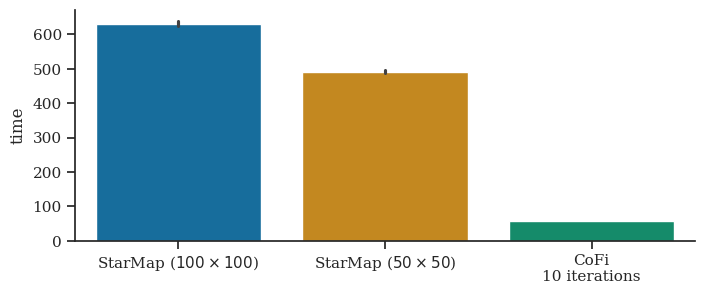

In [291]:
sns.barplot(data=cocktail, x="name", y="time", hue="name", palette="colorblind")
plt.xlabel("")
sns.despine()